# **Import Library**

In [ ]:
# Manipulasi dataframe dan numerik
import pandas as pd
import numpy as np
import ast
from ast import literal_eval

# Tools visualisasi
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Inisialisasi training dan testing data
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

# Algoritma machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluasi kinerja model
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.model_selection import learning_curve

# **Data Preparation**

Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/dataset/dataset.zip

Archive:  drive/MyDrive/dataset/dataset.zip
  inflating: product.csv             
  inflating: customer.csv            
  inflating: click_stream.csv        
  inflating: transactions.csv        


In [ ]:
click = pd.read_csv('/content/drive/MyDrive/dataset/click_stream.csv')
customer = pd.read_csv('/content/drive/MyDrive/dataset/customer.csv')
product = pd.read_csv('/content/drive/MyDrive/dataset/product.csv', usecols=['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName'])
transactions = pd.read_csv('/content/drive/MyDrive/dataset/transactions.csv')

pd.set_option('display.max_columns', None)

## Data Understanding



### Transaction Dataset

In [ ]:
transactions.head()

,created_at,customer_id,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,"[{'product_id': 54728, 'quantity': 1, 'item_pr...",Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,"[{'product_id': 16193, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,"[{'product_id': 53686, 'quantity': 4, 'item_pr...",OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,"[{'product_id': 20228, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,"[{'product_id': 55220, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753


In [ ]:
# mengubah tipe data ke kategori dan date
transactions[['payment_method', 'payment_status', 'promo_code']] = transactions[['payment_method', 'payment_status', 'promo_code']].astype('category')
transactions['shipment_date_limit'] = pd.to_datetime(transactions['shipment_date_limit'])
transactions['created_at'] = pd.to_datetime(transactions['created_at'])

In [ ]:
# parsing metadata dari kolom product_metadata
transactions['product_metadata'] = transactions['product_metadata'].fillna('{}')
transactions['product_metadata'] = transactions['product_metadata'].apply(literal_eval)
transactions = ( transactions.explode('product_metadata').reset_index(drop=True))
transactions = pd.concat([transactions.drop(['product_metadata'], axis=1), pd.json_normalize(transactions['product_metadata'])], axis=1)

transactions.head()

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price
0,2018-07-29 15:22:01.458193+00:00,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03 05:07:24.812676+00:00,-8.227893,111.969107,199832,54728,1,191247
1,2018-07-30 12:40:22.365620+00:00,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03 01:29:03.415705+00:00,3.013470,107.802514,155526,16193,1,145526
2,2018-09-15 11:51:17.365620+00:00,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,NaN,10000,2018-09-18 08:41:49.422380+00:00,-2.579428,115.743885,550696,53686,4,135174
3,2018-11-01 11:23:48.365620+00:00,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,NaN,0,2018-11-05 17:42:27.954235+00:00,-3.602334,120.363824,271012,20228,1,271012
4,2018-12-18 11:20:30.365620+00:00,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,NaN,0,2018-12-23 17:24:07.361785+00:00,-3.602334,120.363824,198753,55220,1,198753


In [ ]:
transactions_selected = ['payment_method','payment_status','promo_code',]

for col_name in transactions_selected:
    print(col_name)
    print(transactions[col_name].unique())
    print('\n')

payment_method
['Debit Card', 'Credit Card', 'OVO', 'LinkAja', 'Gopay']
Categories (5, object): ['Credit Card', 'Debit Card', 'Gopay', 'LinkAja', 'OVO']


payment_status
['Success', 'Failed']
Categories (2, object): ['Failed', 'Success']


promo_code
['WEEKENDSERU', NaN, 'WEEKENDMANTAP', 'AZ2022', 'LIBURDONG', 'BUYMORE', 'XX2022', 'STARTUP', 'SC2022']
Categories (8, object): ['AZ2022', 'BUYMORE', 'LIBURDONG', 'SC2022', 'STARTUP', 'WEEKENDMANTAP',
                         'WEEKENDSERU', 'XX2022']




In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254585 entries, 0 to 1254584
Data columns (total 16 columns):
 #   Column                  Non-Null Count    Dtype              
---  ------                  --------------    -----              
 0   created_at              1254585 non-null  datetime64[ns, UTC]
 1   customer_id             1254585 non-null  int64              
 2   booking_id              1254585 non-null  object             
 3   session_id              1254585 non-null  object             
 4   payment_method          1254585 non-null  category           
 5   payment_status          1254585 non-null  category           
 6   promo_amount            1254585 non-null  int64              
 7   promo_code              481139 non-null   category           
 8   shipment_fee            1254585 non-null  int64              
 9   shipment_date_limit     1254585 non-null  datetime64[ns, UTC]
 10  shipment_location_lat   1254585 non-null  float64            
 11  shipment_lo

In [ ]:
transactions.isnull().sum()

created_at                     0
customer_id                    0
booking_id                     0
session_id                     0
payment_method                 0
payment_status                 0
promo_amount                   0
promo_code                773446
shipment_fee                   0
shipment_date_limit            0
shipment_location_lat          0
shipment_location_long         0
total_amount                   0
product_id                     0
quantity                       0
item_price                     0
dtype: int64

In [ ]:
# Mengubah data NaN pada kolom promo_code menjadi None
transactions['promo_code'] = transactions['promo_code'].cat.add_categories(['None']).fillna('None')

In [ ]:
transactions.duplicated().sum()

0

### Click Stream Dataset

In [ ]:
click.head()

,session_id,event_name,event_time,event_id,traffic_source,event_metadata
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01T12:06:33.322763Z,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,"{'product_id': 15315, 'quantity': 4, 'item_pri..."
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01T12:15:29.425431Z,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,{'payment_status': 'Success'}


In [ ]:
# mengubah tipe data ke kategori dan date
click[['event_name', 'traffic_source']] = click[['event_name', 'traffic_source']].astype('category')
click['event_time'] = pd.to_datetime(click['event_time'])

In [ ]:
# parsing metadata dari kolom event_metadata
def parse_event_metadata(row):
  if pd.isnull(row) or row == '':
    return {}
  return ast.literal_eval(row)

click['event_metadata'] = click['event_metadata'].apply(parse_event_metadata)

metadata_keys = set()

def extract_keys(row):
  for key in row.keys():
    metadata_keys.add(key)

click['event_metadata'].apply(extract_keys)
metadata_keys

{'item_price',
 'payment_status',
 'product_id',
 'promo_amount',
 'promo_code',
 'quantity',
 'search_keywords'}

In [ ]:
click['product_id'] = click['event_metadata'].apply(lambda x: x.get('product_id'))
click['quantity'] = click['event_metadata'].apply(lambda x: x.get('quantity'))
click['item_price'] = click['event_metadata'].apply(lambda x: x.get('item_price'))
click['payment_status'] = click['event_metadata'].apply(lambda x: x.get('payment_status'))
click['product_amount'] = click['event_metadata'].apply(lambda x: x.get('product_amount'))
click['promo_code'] = click['event_metadata'].apply(lambda x: x.get('promo_code'))
click['search_keywords'] = click['event_metadata'].apply(lambda x: x.get('search_keywords'))

# Menghapus kolom event_metadata asli
click.drop(columns=['event_metadata'], inplace=True)
click.head()

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,product_amount,promo_code,search_keywords
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06 15:54:32.821085+00:00,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN,NaN,NaN,None,None,None,None
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06 16:03:57.821085+00:00,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN,NaN,NaN,None,None,None,None
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01 12:05:10.322763+00:00,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN,NaN,NaN,None,None,None,None
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01 12:06:33.322763+00:00,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,15315.0,4.0,313529.0,None,None,None,None
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01 12:15:29.425431+00:00,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,NaN,NaN,NaN,Success,None,None,None


In [ ]:
click_selected = ['event_name', 'traffic_source', 'payment_status','product_amount', 'promo_code', 'search_keywords']

for col_name in click_selected:
    print(col_name)
    print(click[col_name].unique())
    print('\n')

event_name
['HOMEPAGE', 'SCROLL', 'ADD_TO_CART', 'BOOKING', 'SEARCH', 'ITEM_DETAIL', 'ADD_PROMO', 'CLICK', 'PROMO_PAGE']
Categories (9, object): ['ADD_PROMO', 'ADD_TO_CART', 'BOOKING', 'CLICK', ..., 'ITEM_DETAIL',
                         'PROMO_PAGE', 'SCROLL', 'SEARCH']


traffic_source
['MOBILE', 'WEB']
Categories (2, object): ['MOBILE', 'WEB']


payment_status
[None 'Success' 'Failed']


product_amount
[None]


promo_code
[None 'AZ2022' 'BUYMORE' 'WEEKENDSERU' 'XX2022' 'LIBURDONG'
 'WEEKENDMANTAP' 'STARTUP' 'SC2022']


search_keywords
[None 'Dress Kondangan' 'Tas Wanita' 'Celana Panjang' 'Kaos' 'Sepatu'
 'Tas Kerja' 'T-Shirt' 'Topi' 'Bekas' 'Baju' 'Thrift' 'Sepatu Nike'
 'Dress Pesta' 'Sepatu Adidas' 'Second' 'T-shirt' 'Jam' 'Celana'
 'Second Hand' 'Barang Bekas' 'Sendal' 'Daster' 'Baju Tidur']




In [ ]:
# Menghapus kolom product_amount karena tidak ada data
click.drop('product_amount', axis=1, inplace=True)

In [ ]:
# mengubah tipe data kategori
click[['payment_status', 'search_keywords', 'promo_code']] = click[['payment_status', 'search_keywords', 'promo_code']].astype('category')

In [ ]:
click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12833602 entries, 0 to 12833601
Data columns (total 11 columns):
 #   Column           Dtype              
---  ------           -----              
 0   session_id       object             
 1   event_name       category           
 2   event_time       datetime64[ns, UTC]
 3   event_id         object             
 4   traffic_source   category           
 5   product_id       float64            
 6   quantity         float64            
 7   item_price       float64            
 8   payment_status   category           
 9   promo_code       category           
 10  search_keywords  category           
dtypes: category(5), datetime64[ns, UTC](1), float64(3), object(2)
memory usage: 648.7+ MB


In [ ]:
click.describe()

,product_id,quantity,item_price
count,1.937157e+06,1.937157e+06,1.937157e+06
mean,2.912155e+04,1.439845e+00,2.676407e+05
std,1.702633e+04,1.488880e+00,1.181620e+05
min,1.163000e+03,1.000000e+00,5.600000e+03
25%,1.398700e+04,1.000000e+00,1.815350e+05
50%,2.795100e+04,1.000000e+00,2.507430e+05
75%,4.387300e+04,1.000000e+00,3.354100e+05
max,6.000000e+04,4.800000e+01,1.335959e+06


In [ ]:
click.isnull().sum()

session_id                0
event_name                0
event_time                0
event_id                  0
traffic_source            0
product_id         10896445
quantity           10896445
item_price         10896445
payment_status     11981020
promo_code         12507067
search_keywords    11660336
dtype: int64

In [ ]:
click.duplicated().sum()

0

### Customer Dataset

In [ ]:
# mengubah tipe data kategori dan date
customer[['gender','device_type', 'device_version', 'home_location', 'home_country']] = customer[['gender','device_type', 'device_version', 'home_location', 'home_country']].astype('category')
customer['birthdate'] = pd.to_datetime(customer['birthdate'])
customer['first_join_date'] = pd.to_datetime(customer['first_join_date'])

In [ ]:
customer.isnull().sum()

customer_id           0
first_name            0
last_name             0
username              0
email                 0
gender                0
birthdate             0
device_type           0
device_id             0
device_version        0
home_location_lat     0
home_location_long    0
home_location         0
home_country          0
first_join_date       0
dtype: int64

In [ ]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   customer_id         100000 non-null  int64         
 1   first_name          100000 non-null  object        
 2   last_name           100000 non-null  object        
 3   username            100000 non-null  object        
 4   email               100000 non-null  object        
 5   gender              100000 non-null  category      
 6   birthdate           100000 non-null  datetime64[ns]
 7   device_type         100000 non-null  category      
 8   device_id           100000 non-null  object        
 9   device_version      100000 non-null  category      
 10  home_location_lat   100000 non-null  float64       
 11  home_location_long  100000 non-null  float64       
 12  home_location       100000 non-null  category      
 13  home_country        100000 non

In [ ]:
customer.duplicated().sum()

0

### Product Dataset

In [ ]:
product.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


Memastikan jika kolom "id" di dataset product adalah id produk, jika dilakukan penggabungan dengan dataset lain yang memiliki kolom "product_id" berhasil maka id product merujuk ke id produk

In [ ]:
product.rename(columns={'id': 'product_id'}, inplace=True)
product_x_click = pd.merge(product, click, on='product_id', how='inner')
product_x_click.head()

,product_id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,session_id,event_name,event_time,event_id,traffic_source,quantity,item_price,payment_status,promo_code,search_keywords
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,ce3ada0f-bd3a-40e0-a933-8f7bd812417d,ADD_TO_CART,2022-01-25 09:56:24.961185+00:00,52753fec-fb98-42da-b35c-cca28d0103d7,MOBILE,1.0,413183.0,NaN,NaN,NaN
1,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,0806fe9f-3475-4a96-a991-c3bb6e85cf30,ADD_TO_CART,2020-07-03 09:01:12.094909+00:00,9efc2d68-d227-4be9-ab95-4115a151150b,MOBILE,1.0,303483.0,NaN,NaN,NaN
2,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,a3681a9f-e161-49fc-bc3a-93a55500b374,ADD_TO_CART,2021-12-23 08:27:48.329807+00:00,347fc38c-a83c-4872-9c00-e2a0ee43f7c1,MOBILE,1.0,164663.0,NaN,NaN,NaN
3,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,70c38821-65ea-40ea-958d-4a315a634c80,ADD_TO_CART,2018-01-30 03:53:55.445122+00:00,6af63ae8-a5bd-4573-a25a-4430a7ddbf67,MOBILE,1.0,310368.0,NaN,NaN,NaN
4,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,7f778339-055c-4198-b7c1-eab4c5e94e55,ADD_TO_CART,2020-03-28 21:36:47.648053+00:00,ee833d07-8ed8-4111-aa49-3394e489c7bf,MOBILE,1.0,200920.0,NaN,NaN,NaN


In [ ]:
product_x_click.shape

(1937157, 20)

In [ ]:
# mengubah tipe data kategori dan date
product[['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage', 'productDisplayName']] = product[['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage', 'productDisplayName']].astype('category')
product['year'] = pd.to_datetime(product['year'])

In [ ]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   product_id          44446 non-null  int64         
 1   gender              44446 non-null  category      
 2   masterCategory      44446 non-null  category      
 3   subCategory         44446 non-null  category      
 4   articleType         44446 non-null  category      
 5   baseColour          44431 non-null  category      
 6   season              44425 non-null  category      
 7   year                44445 non-null  datetime64[ns]
 8   usage               44129 non-null  category      
 9   productDisplayName  44439 non-null  category      
dtypes: category(8), datetime64[ns](1), int64(1)
memory usage: 2.4 MB


In [ ]:
product.isnull().sum()

product_id              0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [ ]:
product.duplicated().sum()

0

## Exploratory Data  Analysis

<Axes: >

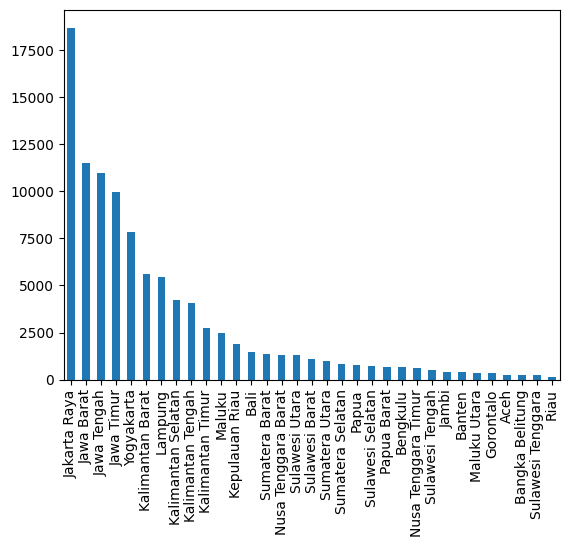

In [ ]:
# Melihat Persebaran Customer
customer['home_location'].value_counts()[0:].plot(kind='bar')

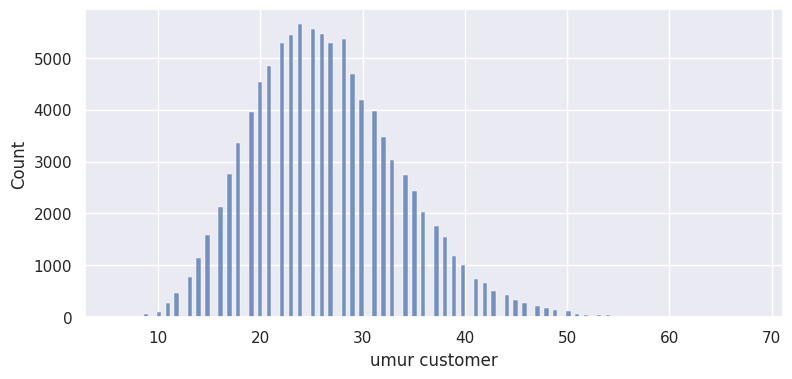

In [ ]:
# Melihat Persebaran Umur Customer
#customer['umur'] = 2022-customer['birthdate'].dt.year
#sns.histplot(customer['umur'])
#plt.xlabel("umur customer")
#plt.show()

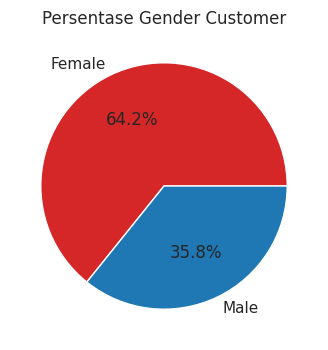

In [ ]:
# Melihat Peresentase Persebaran Gender Customer
x = ["Female", "Male"]
a = customer[customer["gender"] == "F"]["gender"].count()
b = customer[customer["gender"] == "M"]["gender"].count()
y = np.array([a, b])
plt.figure(figsize=(5,4))
bar_colors = ['tab:red', 'tab:blue']
plt.pie(y, labels = x, colors = bar_colors, autopct='%1.1f%%')
plt.title("Persentase Gender Customer")
plt.show()

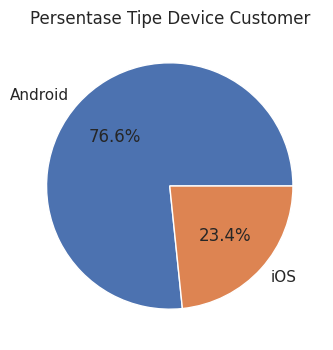

In [ ]:
# Melihat Presentase Tipe Device Customer
plt.figure(figsize=(6,4))
plt.pie(customer['device_type'].value_counts(),
        autopct="%1.1f%%",
        labels=customer['device_type'].value_counts().index)
plt.title("Persentase Tipe Device Customer")
plt.show()

<Axes: xlabel='month_join', ylabel='customers_join'>

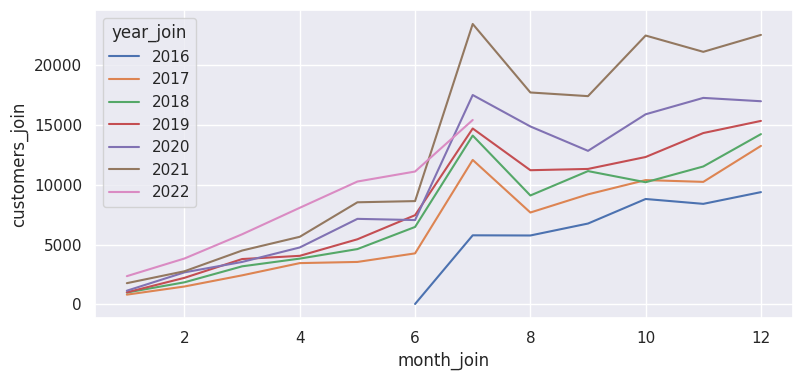

In [ ]:
# Melihat Jumlah Pelanggan Yang Bergabung Berdasarkan Tahun dan Bulan
date = customer.copy()
date['first_join_date'] = pd.to_datetime(date['first_join_date'])

# partisi berdasarkan year dan month
date['year_join'] = date['first_join_date'].dt.year
date['month_join'] = date['first_join_date'].dt.month

month = date.groupby(['year_join', 'month_join']).agg(
    customers_join = pd.NamedAgg(column = 'month_join', aggfunc = sum))
month.reset_index(inplace=True)

sns.set(rc={"figure.figsize":(9, 4)})
sns.lineplot(data=month, x="month_join", y="customers_join", hue="year_join", palette="deep")

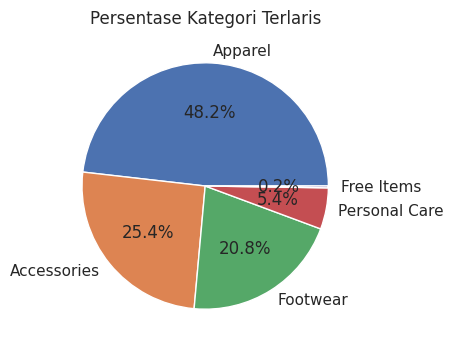

In [ ]:
# Melihat Presentase Kategori Terlaris
customer_product=transactions.merge(product[['product_id','masterCategory','subCategory','articleType','season']],on='product_id',how='left')
customer_product=customer_product.merge(customer[['customer_id','gender']],on='customer_id',how='left')

plt.figure(figsize=(6,4))
plt.pie(customer_product['masterCategory'].value_counts()[:5],
        autopct="%1.1f%%",
        labels=customer_product['masterCategory'].value_counts()[:5].index)
plt.title("Persentase Kategori Terlaris")
plt.show()

Text(0.5, 1.0, 'Penjualan Pakaian Terlaris')

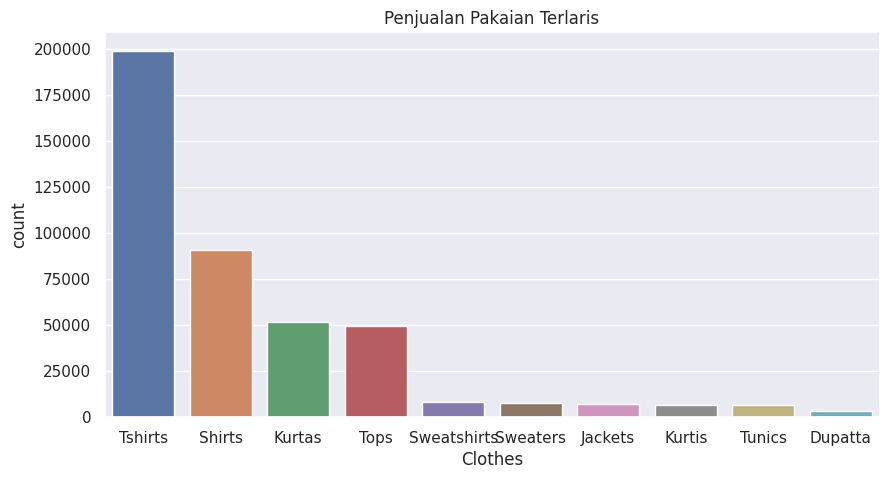

In [ ]:
# Jenis pakaian yang paling banyak diminati oleh customer
topwear = customer_product[customer_product['subCategory'] == 'Topwear'].copy()
topwear.rename(columns = {"articleType":"Clothes"},inplace=True)
plt.figure(figsize=(10,5))
sns.countplot(x = 'Clothes',
              data = topwear,
              order = topwear['Clothes'].value_counts()[:10].index)
plt.title('Penjualan Pakaian Terlaris')

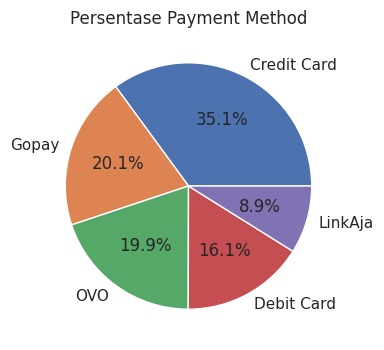

In [ ]:
# Melihat Presentasi Payment Method
plt.figure(figsize=(6,4))
plt.pie(transactions["payment_method"].value_counts(),
        autopct="%1.1f%%",
        labels=transactions['payment_method'].value_counts().index)
plt.title("Persentase Payment Method")
plt.show()

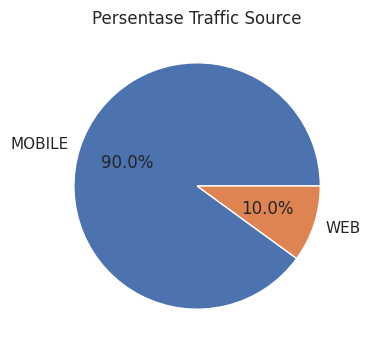

In [ ]:
# Melihat presentase trafik
plt.figure(figsize=(6,4))
plt.pie(click["traffic_source"].value_counts(),
        autopct="%1.1f%%",
        labels=click['traffic_source'].value_counts().index)
plt.title("Persentase Traffic Source")
plt.show()

Menganalisa presentase pelanggan yang sukses melakukan pembelian

Jumlah customers terdaftar: 100000
Jumlah customers yang pernah bertransaksi: 50705
Jumlah customers yang sukses bertransaksi: 50242


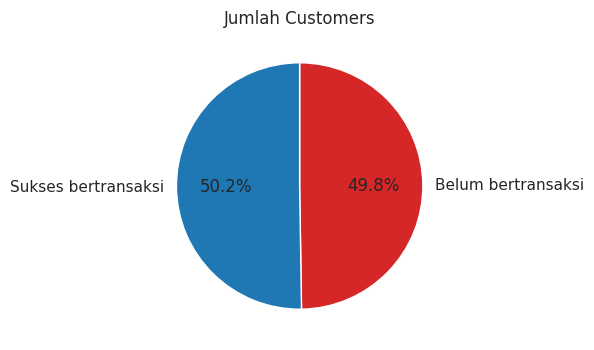

In [ ]:
# Memfilter Transactions yang Memiliki Payment Status = Success
success = transactions.copy()
success = transactions[transactions['payment_status'] == 'Success']

total = customer['customer_id'].nunique()
trans_sukses = success['customer_id'].nunique()
no_trans = total-trans_sukses

print('Jumlah customers terdaftar:', total)
print('Jumlah customers yang pernah bertransaksi:', transactions['customer_id'].nunique())
print('Jumlah customers yang sukses bertransaksi:', trans_sukses)

# Memastikan bahwa nilai-nilai di dalam array y bersifat non-negatif
x = ["Belum bertransaksi", "Sukses bertransaksi"]
y = np.array([no_trans, trans_sukses])  # Memastikan bahwa c diubah menjadi positif

bar_colors = ['tab:red', 'tab:blue']

# Membuat diagram lingkaran dengan sektor "Sukses bertransaksi" muncul terlebih dahulu
plt.figure(figsize=(6, 4))
plt.pie(y, labels=x, colors=bar_colors, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Jumlah Customers')
plt.show()

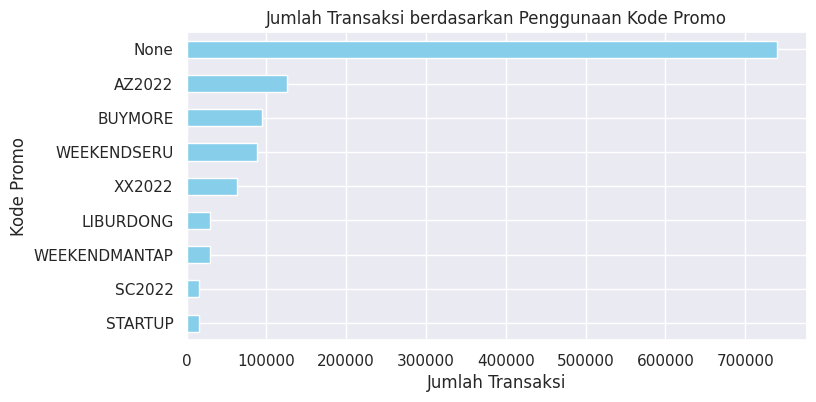

In [ ]:
# Menampilkan transaksi yang sukses berdasarkan kode promo
success['promo_code'].value_counts().sort_values().plot(kind='barh', color='skyblue', figsize=(8, 4))
plt.xlabel('Jumlah Transaksi')
plt.ylabel('Kode Promo')
plt.title('Jumlah Transaksi berdasarkan Penggunaan Kode Promo')
plt.show()

<ipython-input-48-1a84d191071b>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  transactions['year'] = transactions['created_at'].dt.to_period('Y')


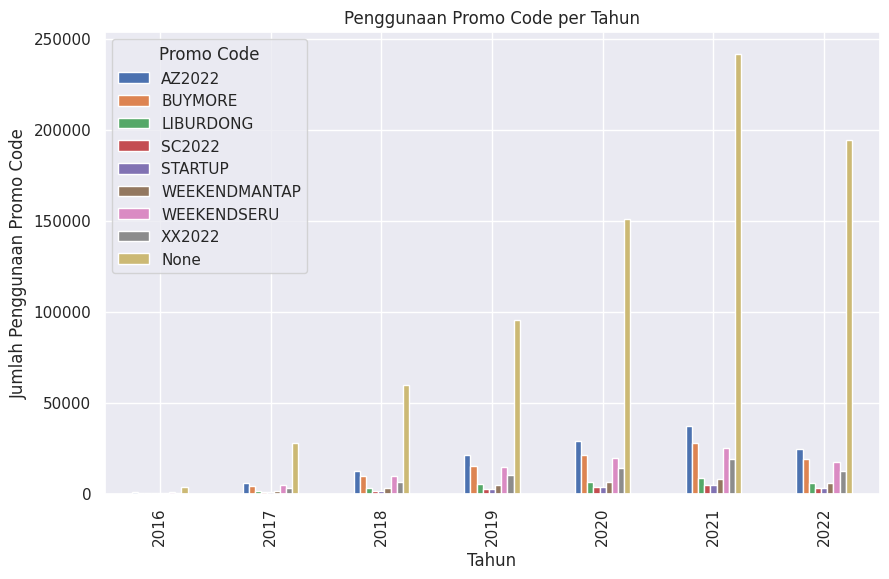

In [ ]:
# Menampilkan penggunaan kode promo dari tahun ke tahun
transactions['year'] = transactions['created_at'].dt.to_period('Y')

# Groupby berdasarkan Tahun dan promo_code, lalu hitung jumlah penggunaan promo_code
grouped_data = transactions.groupby(['year', 'promo_code']).size().unstack(fill_value=0)

# Membuat diagram batang tanpa stacking
grouped_data.plot(kind='bar', figsize=(10, 6), stacked=False)

# Menampilkan diagram
plt.xlabel('Tahun')
plt.ylabel('Jumlah Penggunaan Promo Code')
plt.title('Penggunaan Promo Code per Tahun')
plt.legend(title='Promo Code', title_fontsize='12')
plt.show()

<Axes: xlabel='month_transaction', ylabel='customers_transaction'>

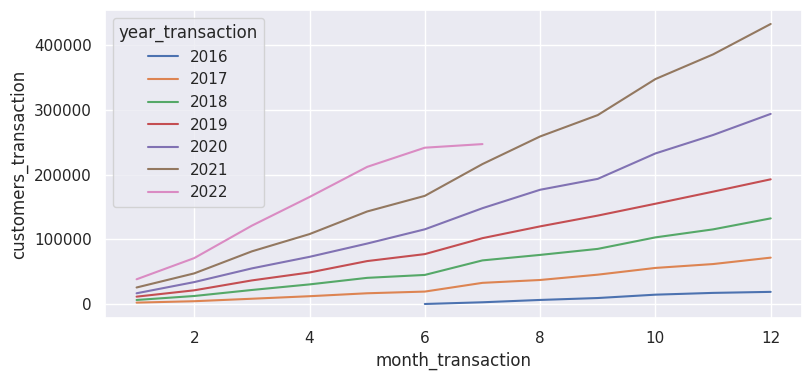

In [ ]:
# Menampilkan transaksi sukses dari tahun ke tahun
date = success.copy()
date['year_transaction'] = date['created_at'].dt.year
date['month_transaction'] = date['created_at'].dt.month

month = date.groupby(['year_transaction', 'month_transaction']).agg(
    customers_transaction = pd.NamedAgg(column = 'month_transaction', aggfunc = sum))
month.reset_index(inplace=True)

sns.set(rc={"figure.figsize":(9, 4)})
sns.lineplot(data=month, x="month_transaction", y="customers_transaction", hue="year_transaction", palette="deep")

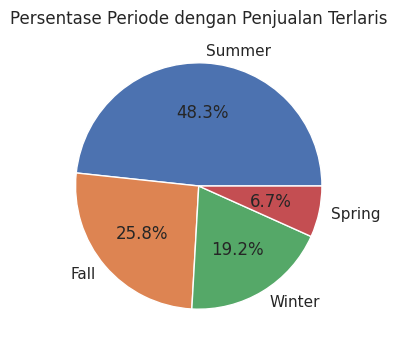

In [ ]:
#Presentase penjualan sukses berdasarkan musim
success = transactions.copy()
success = transactions[transactions['payment_status'] == 'Success']

product_transactions = success.merge(product, how='left', on='product_id')
season = product_transactions.groupby('season')['quantity'].sum()
plt.figure(figsize=(6,4))
plt.pie(season.sort_values(ascending=False),
        autopct="%1.1f%%",
        labels=season.sort_values(ascending=False).index)
plt.title("Persentase Periode dengan Penjualan Terlaris")
plt.show()

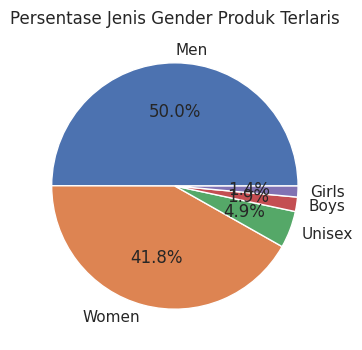

In [ ]:
#Presentase penjualan sukses berdasarkan gender produk
gender = product_transactions.groupby('gender')['quantity'].sum()
plt.figure(figsize=(6,4))
plt.pie(gender.sort_values(ascending=False),
        autopct="%1.1f%%",
        labels=gender.sort_values(ascending=False).index)
plt.title("Persentase Jenis Gender Produk Terlaris")
plt.show()

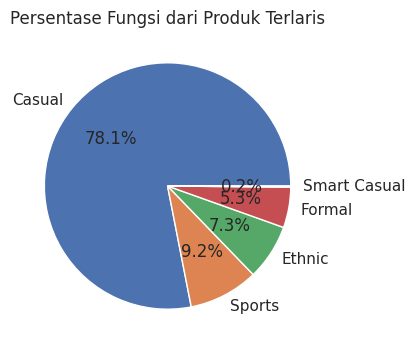

In [ ]:
# Melihat presentase produk terlaris dari fungsinya
usage = product_transactions.groupby('usage')['quantity'].sum()
plt.figure(figsize=(6,4))
plt.pie(usage.sort_values(ascending=False)[:5],
        autopct="%1.1f%%",
        labels=usage.sort_values(ascending=False)[:5].index)
plt.title("Persentase Fungsi dari Produk Terlaris")
plt.show()

<Axes: ylabel='subCategory'>

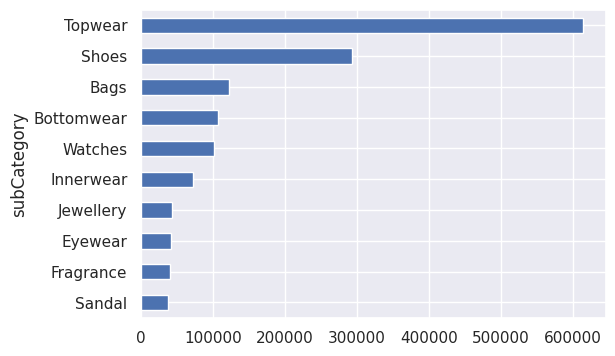

In [ ]:
# Melihat presentase produk terlaris dari subcategory
subCategory = product_transactions.groupby('subCategory')['quantity'].sum()
plt.figure(figsize=(6,4))
subCategory.sort_values(ascending=False)[:10].sort_values().plot(kind='barh')

<Axes: ylabel='articleType'>

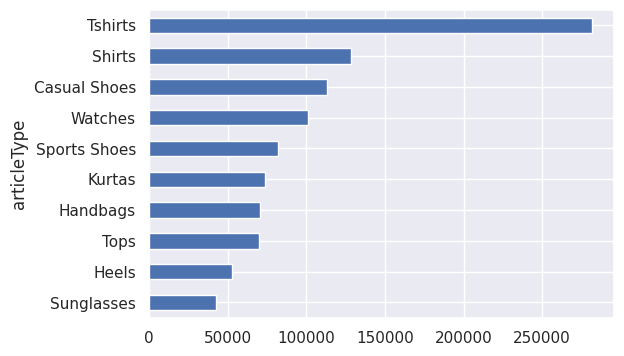

In [ ]:
# Melihat presentase produk terlaris dari articletype
articleType = product_transactions.groupby('articleType')['quantity'].sum()
plt.figure(figsize=(6,4))
articleType.sort_values(ascending=False)[:10].sort_values().plot(kind='barh')

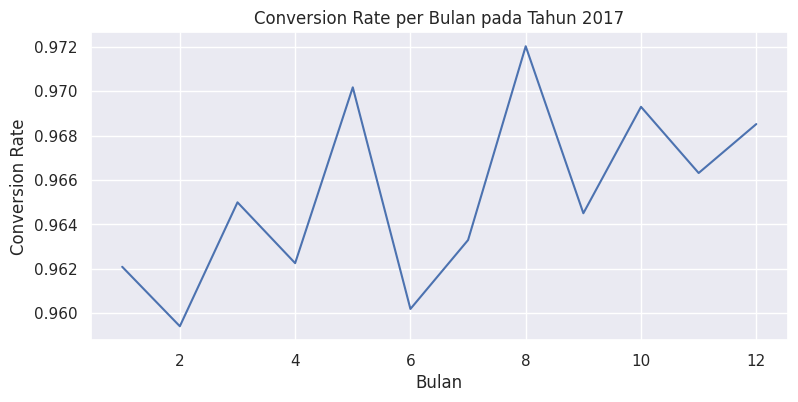

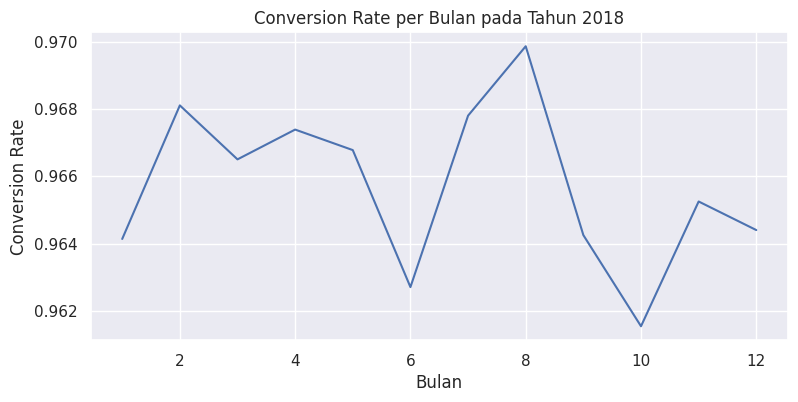

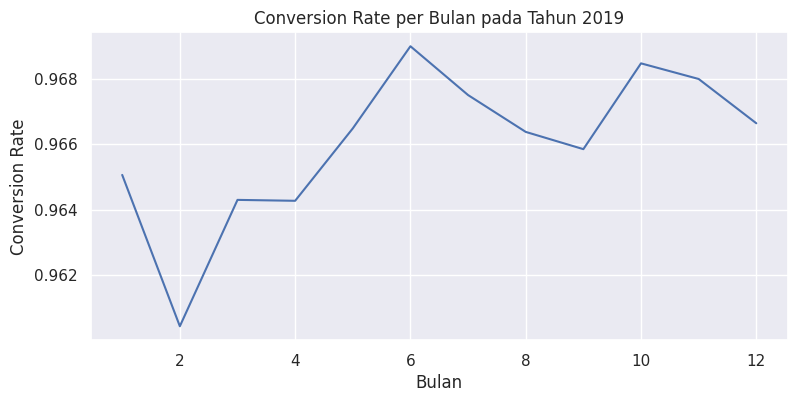

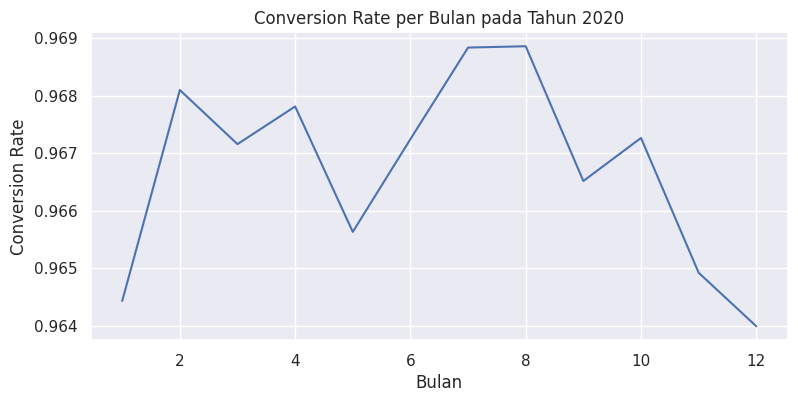

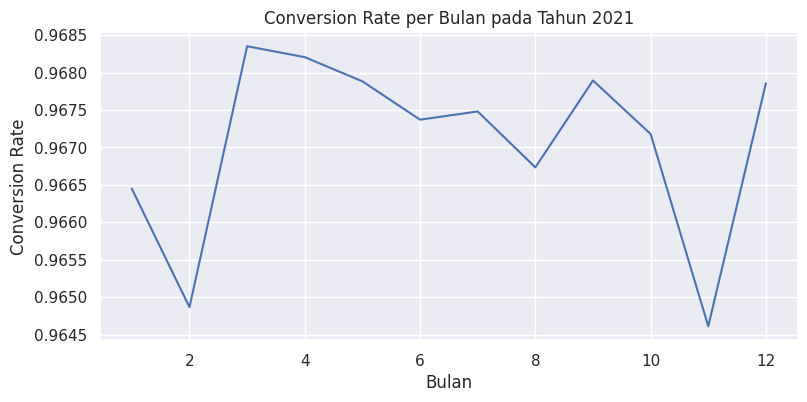

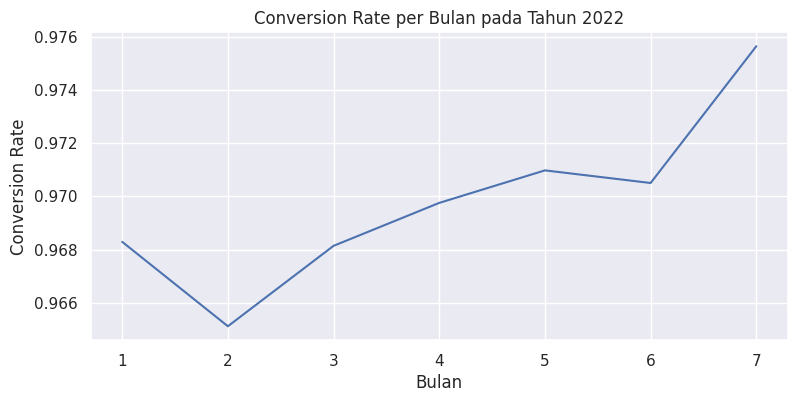

In [ ]:
# Menampilkan Conversion Rate setiap bulan pertahun nya
years_to_analyze = [2017, 2018, 2019, 2020, 2021, 2022]

for year in years_to_analyze:
  # Filter data berdasarkan tahun
  transactions_year = transactions[transactions['created_at'].dt.year == year]

  # Hitung jumlah pengunjung yang berhasil melakukan pembayaran per bulan
  successful_payments_per_month = transactions_year[transactions_year['payment_status'] == 'Success'].groupby(transactions_year['created_at'].dt.month)['customer_id'].nunique()

  # Hitung jumlah pengunjung secara keseluruhan per bulan
  total_visitors_per_month = transactions_year.groupby(transactions_year['created_at'].dt.month)['customer_id'].nunique()

  # Hitung conversion rate per bulan
  conversion_rate_per_month = (successful_payments_per_month / total_visitors_per_month).fillna(0)

  # Plot data conversion rate
  plt.figure()
  conversion_rate_per_month.plot(kind='line', xlabel='Bulan', ylabel='Conversion Rate')
  plt.title(f'Conversion Rate per Bulan pada Tahun {year}')

plt.show()

Conversion Rate: 0.00%


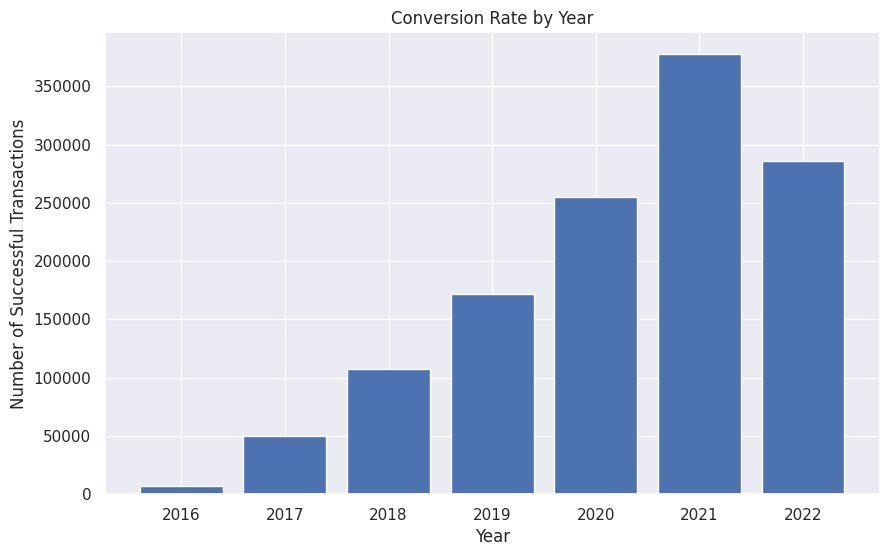

In [ ]:
# Menampilkan Conversion Rate dari tahun ke tahun
successful_transactions = transactions[transactions['payment_status'].isin(['success', 'completed'])]
unique_customers = transactions['customer_id'].nunique()
num_successful_transactions = successful_transactions.shape[0]
conversion_rate = (num_successful_transactions / unique_customers) * 100
print(f'Conversion Rate: {conversion_rate:.2f}%')

transactions['created_at'] = pd.to_datetime(transactions['created_at'])
transactions['year'] = transactions['created_at'].dt.year
conversion_by_year = transactions.groupby('year')['payment_status'].count()
plt.figure(figsize=(10, 6))
plt.bar(conversion_by_year.index, conversion_by_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Successful Transactions')
plt.title('Conversion Rate by Year')
plt.show()

Jumlah dan Jenis Status Pembayaran:
Success    815962
Failed      36620
Name: payment_status, dtype: int64


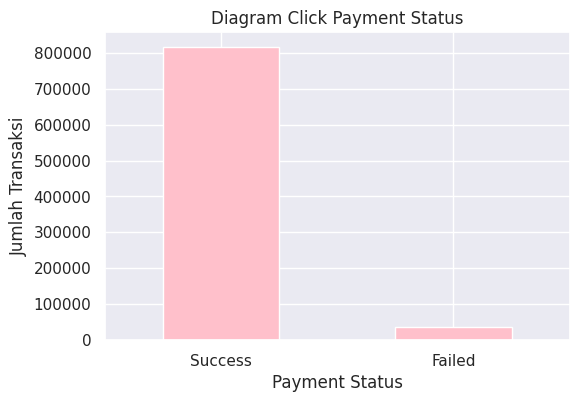

In [ ]:
# Menghitung jumlah setiap nilai dalam 'payment_status'
payment_status_counts = click['payment_status'].value_counts()
print("Jumlah dan Jenis Status Pembayaran:")
print(payment_status_counts)

# Membuat plot
plt.figure(figsize=(6, 4))
payment_status_counts.plot(kind='bar', color='pink')
plt.xlabel('Payment Status')
plt.ylabel('Jumlah Transaksi')
plt.title('Diagram Click Payment Status')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Menghitung jumlah payment method dengan status 'success'
success_count = transactions[transactions['payment_status'] == 'Success']['payment_method'].value_counts()

# Menghitung jumlah payment method dengan status 'failed'
failed_count = transactions[transactions['payment_status'] == 'Failed']['payment_method'].value_counts()

print("Jumlah payment method dengan status 'success':")
print(success_count)

print("\nJumlah payment method dengan status 'failed':")
print(failed_count)

Jumlah payment method dengan status 'success':
Credit Card    420997
Gopay          240951
OVO            238745
Debit Card     193705
LinkAja        106637
Name: payment_method, dtype: int64

Jumlah payment method dengan status 'failed':
Credit Card    18879
Gopay          10626
OVO            10320
Debit Card      8847
LinkAja         4878
Name: payment_method, dtype: int64


In [ ]:
# Menghitung jumlah dan kata kunci (search keywords)
search_keywords_counts = click['search_keywords'].value_counts()

# Menampilkan hasil
print("Jumlah dan Kata Kunci:")
print(search_keywords_counts)

Jumlah dan Kata Kunci:
Dress Kondangan    256194
Tas Wanita         128790
Bekas              112269
T-Shirt            100087
Baju                83873
Kaos                83759
Dress Pesta         76829
Sepatu Nike         51578
Tas Kerja           38677
Second Hand         28429
Second              28195
Thrift              28171
Sepatu              28029
Celana Panjang      28009
Barang Bekas        27818
Sepatu Adidas       25627
Sendal              12787
Celana              11739
T-shirt              7097
Jam                  7000
Topi                 4844
Baju Tidur           2268
Daster               1197
Name: search_keywords, dtype: int64


In [ ]:
# Mengetahui jumlah transactions dari seluruh customers

# Menghitung jumlah pembelian per pelanggan di dataset transactions
total_purchase_counts = transactions.groupby('customer_id').size().reset_index(name='total_purchase_count')

# Gabungkan hasil dengan data customer menggunakan 'outer'
result_customer = pd.merge(customer, total_purchase_counts, on='customer_id', how='outer')

# Mengganti nilai NaN pada kolom 'total_purchase_count' dengan 0
result_customer['total_purchase_count'].fillna(0, inplace=True)

# Mengubah tipe data
result_customer['total_purchase_count'] = result_customer['total_purchase_count'].astype(int)

# Mengurutkan hasil berdasarkan 'total_purchase_count'
result_customer = result_customer.sort_values(by='total_purchase_count',ascending=[0])

# Menyusun ulang indeks jika diperlukan
result_customer = result_customer.reset_index(drop=True)

# Menampilkan hasil
result_customer[['customer_id','first_name','last_name','gender','total_purchase_count']]

,customer_id,first_name,last_name,gender,total_purchase_count
0,43202,Siti,Suartini,F,807
1,29496,Eva,Usada,F,749
2,82237,Tari,Wastuti,F,716
3,10167,Queen,Mandasari,F,693
4,69740,Eva,Usada,F,673
...,...,...,...,...,...
99995,26228,Puji,Pertiwi,F,0
99996,33770,Aditya,Jailani,M,0
99997,38402,Raina,Farida,F,0
99998,3621,Rina,Haryanti,F,0


In [ ]:
# Menghitung total pembelian per pelanggan di dataset transactions
total_purchase_amount = transactions.groupby('customer_id')['total_amount'].sum().reset_index(name='total_purchase_amount')

# Gabungkan hasil dengan data customer menggunakan 'outer'
result_customer = pd.merge(customer, total_purchase_amount, on='customer_id', how='outer')

# Mengganti nilai NaN pada kolom 'total_purchase_amount' dengan 0
result_customer['total_purchase_amount'].fillna(0, inplace=True)

# Mengubah tipe data
result_customer['total_purchase_amount'] = result_customer['total_purchase_amount'].astype(int)

# Mengurutkan hasil berdasarkan 'customer_id'
result_customer = result_customer.sort_values(by='total_purchase_amount',ascending=[0])

# Menyusun ulang indeks jika diperlukan
result_customer = result_customer.reset_index(drop=True)

# Menampilkan hasil
result_customer[['customer_id','first_name','last_name','gender','total_purchase_amount']]

,customer_id,first_name,last_name,gender,total_purchase_amount
0,52130,Juli,Winarsih,F,1116077254
1,43202,Siti,Suartini,F,1107963164
2,65858,Rina,Riyanti,F,1101132219
3,85994,Sakura,Astuti,F,1098440883
4,29496,Eva,Usada,F,1070901435
...,...,...,...,...,...
99995,26228,Puji,Pertiwi,F,0
99996,33770,Aditya,Jailani,M,0
99997,38402,Raina,Farida,F,0
99998,3621,Rina,Haryanti,F,0


In [ ]:
# Menampilkan productDisplay Name dan baseColour ke dataset transactions

# Menggabungkan dataset transactions dan product berdasarkan kolom 'product_id' dan 'id'
merged_data = transactions.merge(product, left_on='product_id', right_on='product_id', how='inner')

# Menghapus kolom yang tidak diperlukan dari DataFrame merged_data
merged_data.drop(['product_id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'season', 'year_y', 'usage'], axis=1, inplace=True)

# Menampilkan hasil gabungan
merged_data[['customer_id','payment_method','payment_status','promo_code','productDisplayName']]

,customer_id,payment_method,payment_status,promo_code,productDisplayName
0,5868,Debit Card,Success,WEEKENDSERU,Vans Men Black Shoes
1,82831,OVO,Success,None,Vans Men Black Shoes
2,47013,Gopay,Success,None,Vans Men Black Shoes
3,17135,Credit Card,Success,None,Vans Men Black Shoes
4,70185,Gopay,Success,None,Vans Men Black Shoes
...,...,...,...,...,...
1254580,9486,Credit Card,Success,AZ2022,Puma Men's Future Cat Engine Black Shoe
1254581,30710,Gopay,Success,None,Puma Men's Future Cat Engine Black Shoe
1254582,86532,Credit Card,Success,XX2022,Puma Men's Future Cat Engine Black Shoe
1254583,83374,Credit Card,Success,None,Puma Men's Future Cat Engine Black Shoe


<ipython-input-63-d1e2b83aa63d>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  transactions['month'] = transactions['created_at'].dt.to_period('M')


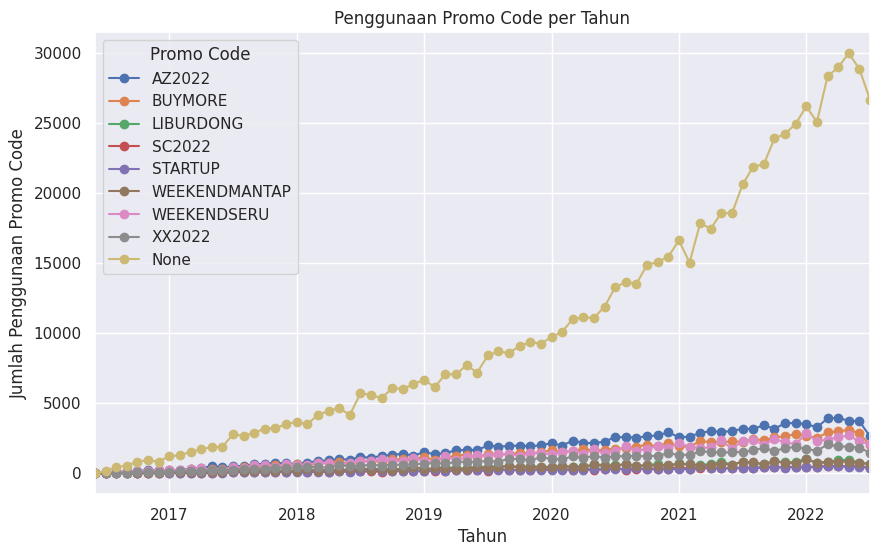

In [ ]:
# Menampilkan penggunaan kode promo tiap tahun nya
transactions['month'] = transactions['created_at'].dt.to_period('M')

# Groupby berdasarkan Tahun dan promo_code, lalu hitung jumlah penggunaan promo_code
grouped_data = transactions.groupby(['month', 'promo_code']).size().unstack(fill_value=0)

# Membuat time series plot
grouped_data.plot(kind='line', marker='o', figsize=(10, 6))
plt.xlabel('Tahun')
plt.ylabel('Jumlah Penggunaan Promo Code')
plt.title('Penggunaan Promo Code per Tahun')
plt.legend(title='Promo Code', title_fontsize='12')
plt.show()

# **3. Feature Engineering**

Total price tanpa shipment_fee

In [ ]:
# Melihat total harga asli tanpa ada harga ongkir ((quantity * item_price))
transactions['total_price'] = transactions['item_price'] * transactions['quantity']
transactions.head()

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price,total_price,transaction_day
0,2018-07-29 15:22:01.458193+00:00,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03 05:07:24.812676+00:00,-8.227893,111.969107,199832,54728,1,191247,191247,Sunday
1,2018-07-30 12:40:22.365620+00:00,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,None,10000,2018-08-03 01:29:03.415705+00:00,3.013470,107.802514,155526,16193,1,145526,145526,Monday
2,2018-09-15 11:51:17.365620+00:00,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,None,10000,2018-09-18 08:41:49.422380+00:00,-2.579428,115.743885,550696,53686,4,135174,540696,Saturday
3,2018-11-01 11:23:48.365620+00:00,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,None,0,2018-11-05 17:42:27.954235+00:00,-3.602334,120.363824,271012,20228,1,271012,271012,Thursday
4,2018-12-18 11:20:30.365620+00:00,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,None,0,2018-12-23 17:24:07.361785+00:00,-3.602334,120.363824,198753,55220,1,198753,198753,Tuesday


Hari cust melakukan transaksi

In [ ]:
transactions['transaction_day'] = transactions['created_at'].dt.day_name()
transactions.head()

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price,total_price,transaction_day
0,2018-07-29 15:22:01.458193+00:00,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03 05:07:24.812676+00:00,-8.227893,111.969107,199832,54728,1,191247,191247,Sunday
1,2018-07-30 12:40:22.365620+00:00,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,None,10000,2018-08-03 01:29:03.415705+00:00,3.013470,107.802514,155526,16193,1,145526,145526,Monday
2,2018-09-15 11:51:17.365620+00:00,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,None,10000,2018-09-18 08:41:49.422380+00:00,-2.579428,115.743885,550696,53686,4,135174,540696,Saturday
3,2018-11-01 11:23:48.365620+00:00,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,None,0,2018-11-05 17:42:27.954235+00:00,-3.602334,120.363824,271012,20228,1,271012,271012,Thursday
4,2018-12-18 11:20:30.365620+00:00,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,None,0,2018-12-23 17:24:07.361785+00:00,-3.602334,120.363824,198753,55220,1,198753,198753,Tuesday


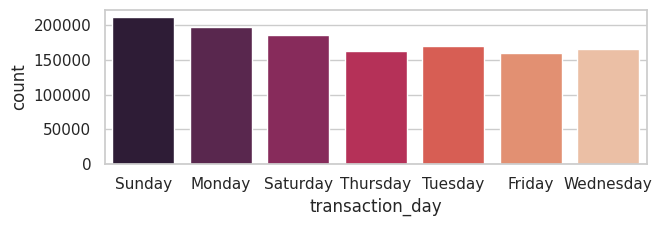

In [ ]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(7, 2))
sns.countplot(x="transaction_day", data=transactions, palette='rocket', ax=ax)
plt.show()

In [ ]:
# Total seluruh transaksi per-harinya
all_transactions_day = transactions.groupby(['transaction_day']).agg(
                   jumlah = pd.NamedAgg(column = 'booking_id', aggfunc = len))

all_transactions_day.reset_index(inplace=True)
all_transactions_day

,transaction_day,jumlah
0,Friday,159780
1,Monday,197518
2,Saturday,186813
3,Sunday,211736
4,Thursday,162954
5,Tuesday,170303
6,Wednesday,165481


In [ ]:
# Jumlah transaksi yang dilakukan customer di masing-masing hari
cust_transaction_day = transactions.groupby(['customer_id', 'transaction_day']).agg(
                          total_days = pd.NamedAgg(column = 'transaction_day', aggfunc = len)
                          )
cust_transaction_day.reset_index(inplace=True)
cust_transaction_day.loc[cust_transaction_day['customer_id'] == 4774]

,customer_id,transaction_day,total_days
10107,4774,Friday,7
10108,4774,Monday,5
10109,4774,Saturday,10
10110,4774,Sunday,5
10111,4774,Thursday,5
10112,4774,Tuesday,5
10113,4774,Wednesday,6


Bulan customer melakukan transaksi

In [ ]:
transactions['transaction_month'] = transactions['created_at'].dt.month_name()
transactions.head()

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price,total_price,transaction_day,transaction_month
0,2018-07-29 15:22:01.458193+00:00,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03 05:07:24.812676+00:00,-8.227893,111.969107,199832,54728,1,191247,191247,Sunday,July
1,2018-07-30 12:40:22.365620+00:00,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,None,10000,2018-08-03 01:29:03.415705+00:00,3.013470,107.802514,155526,16193,1,145526,145526,Monday,July
2,2018-09-15 11:51:17.365620+00:00,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,None,10000,2018-09-18 08:41:49.422380+00:00,-2.579428,115.743885,550696,53686,4,135174,540696,Saturday,September
3,2018-11-01 11:23:48.365620+00:00,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,None,0,2018-11-05 17:42:27.954235+00:00,-3.602334,120.363824,271012,20228,1,271012,271012,Thursday,November
4,2018-12-18 11:20:30.365620+00:00,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,None,0,2018-12-23 17:24:07.361785+00:00,-3.602334,120.363824,198753,55220,1,198753,198753,Tuesday,December


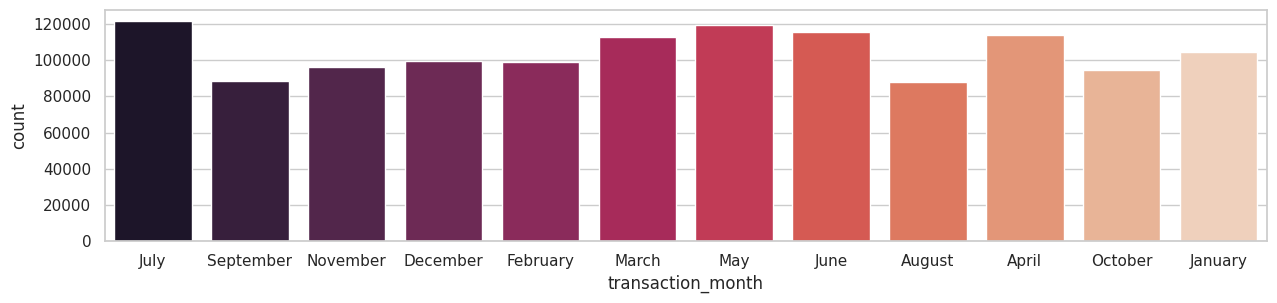

In [ ]:
fig, ax = plt.subplots(figsize=(15, 3))
sns.set(style="whitegrid")
ax = sns.countplot(x="transaction_month", data=transactions, palette='rocket')
plt.show()

In [ ]:
cust_transaction_month = transactions.groupby(['customer_id', 'transaction_month']).agg(
                          total_month = pd.NamedAgg(column = 'transaction_month', aggfunc = len)
                          )
cust_transaction_month.reset_index(inplace=True)
cust_transaction_month.loc[cust_transaction_month['customer_id'] == 4774]

,customer_id,transaction_month,total_month
14443,4774,April,5
14444,4774,August,9
14445,4774,December,3
14446,4774,February,6
14447,4774,January,2
14448,4774,July,3
14449,4774,June,2
14450,4774,March,2
14451,4774,May,3
14452,4774,November,4


Jam customer melakukan transaksi

In [ ]:
transactions['transaction_hour'] = transactions['created_at'].dt.hour
transactions.head()

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price,total_price,transaction_day,transaction_month,transaction_hour
0,2018-07-29 15:22:01.458193+00:00,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03 05:07:24.812676+00:00,-8.227893,111.969107,199832,54728,1,191247,191247,Sunday,July,15
1,2018-07-30 12:40:22.365620+00:00,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,None,10000,2018-08-03 01:29:03.415705+00:00,3.013470,107.802514,155526,16193,1,145526,145526,Monday,July,12
2,2018-09-15 11:51:17.365620+00:00,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,None,10000,2018-09-18 08:41:49.422380+00:00,-2.579428,115.743885,550696,53686,4,135174,540696,Saturday,September,11
3,2018-11-01 11:23:48.365620+00:00,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,None,0,2018-11-05 17:42:27.954235+00:00,-3.602334,120.363824,271012,20228,1,271012,271012,Thursday,November,11
4,2018-12-18 11:20:30.365620+00:00,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,None,0,2018-12-23 17:24:07.361785+00:00,-3.602334,120.363824,198753,55220,1,198753,198753,Tuesday,December,11


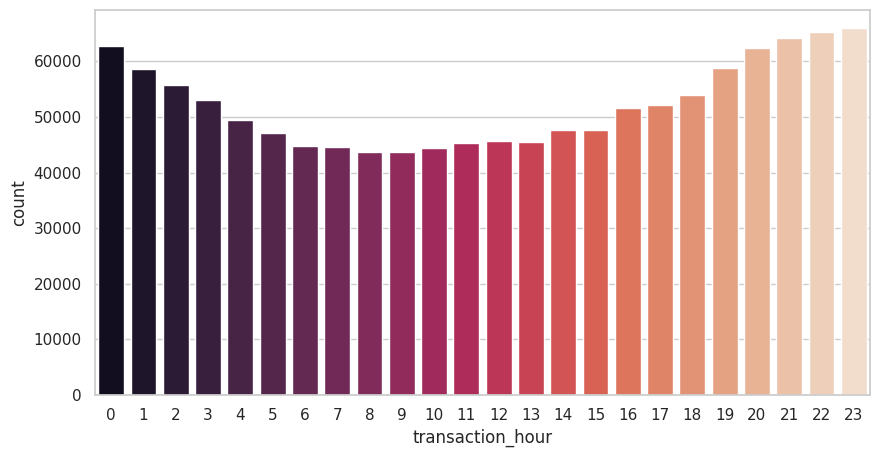

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set(style="whitegrid")
ax = sns.countplot(x="transaction_hour", data=transactions, palette='rocket')
plt.show()

In [ ]:
# Melihat berapa kali transaksi yang dilakukan pada jam tersebut
cust_transaction_hour = transactions.groupby(['customer_id', 'transaction_hour']).agg(
                          total_hours = pd.NamedAgg(column = 'transaction_hour', aggfunc = len)
                          )
cust_transaction_hour.reset_index(inplace=True)
cust_transaction_hour.loc[cust_transaction_hour['customer_id'] == 4774]

,customer_id,transaction_hour,total_hours
15668,4774,10,3
15669,4774,11,29
15670,4774,12,11


Mencari Total transactions, First Transaction, Latest Transaction, Total Quantity, Total Price, Total Shipment Fee, Total Promo Amount, Total Amount per Customer

In [ ]:
customer_transaction_count = transactions.groupby(['customer_id']).agg(
                          total_transactions = pd.NamedAgg(column = 'booking_id', aggfunc = len),
                          first_transaction = pd.NamedAgg(column = 'created_at', aggfunc = min),
                          latest_transaction = pd.NamedAgg(column = 'created_at', aggfunc = max),
                          total_quantity = pd.NamedAgg(column = 'quantity', aggfunc = sum),
                          total_price = pd.NamedAgg(column = 'total_price', aggfunc = sum),
                          total_shipment_fee = pd.NamedAgg(column = 'shipment_fee', aggfunc = sum),
                          total_promo_amount = pd.NamedAgg(column = 'promo_amount', aggfunc = sum),
                          total_amount = pd.NamedAgg(column = 'total_amount', aggfunc = sum)
                          )
customer_transaction_count.reset_index(inplace=True)
customer_transaction_count.head()

,customer_id,total_transactions,first_transaction,latest_transaction,total_quantity,total_price,total_shipment_fee,total_promo_amount,total_amount
0,3,71,2018-08-25 18:54:03.844494+00:00,2022-06-26 15:41:52.844494+00:00,88,21031971,495000,183397,45842098
1,8,8,2021-02-13 09:47:39.656991+00:00,2022-05-15 22:46:22.656991+00:00,19,3861260,55000,7699,4758601
2,9,8,2021-06-27 01:51:48.421034+00:00,2022-05-28 08:44:32.421034+00:00,10,2603665,45000,0,4113630
3,11,1,2022-03-07 14:29:13.759159+00:00,2022-03-07 14:29:13.759159+00:00,1,192025,15000,9492,197533
4,15,9,2019-09-30 04:47:36.105040+00:00,2022-01-05 06:07:58.105040+00:00,9,2101232,90000,16362,6447246


In [ ]:
customer_transaction_count['first_transaction'] = pd.to_datetime(customer_transaction_count['first_transaction'].dt.strftime("%Y-%m-%d"))
customer_transaction_count['latest_transaction'] = pd.to_datetime(customer_transaction_count['latest_transaction'].dt.strftime("%Y-%m-%d"))
customer_transaction_count.head()

,customer_id,total_transactions,first_transaction,latest_transaction,total_quantity,total_price,total_shipment_fee,total_promo_amount,total_amount
0,3,71,2018-08-25,2022-06-26,88,21031971,495000,183397,45842098
1,8,8,2021-02-13,2022-05-15,19,3861260,55000,7699,4758601
2,9,8,2021-06-27,2022-05-28,10,2603665,45000,0,4113630
3,11,1,2022-03-07,2022-03-07,1,192025,15000,9492,197533
4,15,9,2019-09-30,2022-01-05,9,2101232,90000,16362,6447246


## Recency

In [ ]:
# Melihat sudah berapa hari customer melakukan terakhir transaksi
customer_transaction_count['recency'] = (customer_transaction_count['latest_transaction'].max() - customer_transaction_count['latest_transaction']).dt.days
customer_transaction_count.head()

# berarti transaksi terakhir terjadi 35 hari yang lalu pada cust dgn no id 3

,customer_id,total_transactions,first_transaction,latest_transaction,total_quantity,total_price,total_shipment_fee,total_promo_amount,total_amount,recency
0,3,71,2018-08-25,2022-06-26,88,21031971,495000,183397,45842098,35
1,8,8,2021-02-13,2022-05-15,19,3861260,55000,7699,4758601,77
2,9,8,2021-06-27,2022-05-28,10,2603665,45000,0,4113630,64
3,11,1,2022-03-07,2022-03-07,1,192025,15000,9492,197533,146
4,15,9,2019-09-30,2022-01-05,9,2101232,90000,16362,6447246,207


## Tenure (bulan)

sudah berapa bulan cust memakai layanan dari firts join - last trans

In [ ]:
customer_join_date = customer[['customer_id', 'first_join_date']].copy()
customer_join_date.head()

,customer_id,first_join_date
0,2870,2019-07-21
1,8193,2017-07-16
2,7279,2020-08-23
3,88813,2021-10-03
4,82542,2021-04-11


In [ ]:
customer_transaction_count = pd.merge(customer_transaction_count, customer_join_date, on='customer_id',how='left')
customer_transaction_count.head()

,customer_id,total_transactions,first_transaction,latest_transaction,total_quantity,total_price,total_shipment_fee,total_promo_amount,total_amount,recency,first_join_date
0,3,71,2018-08-25,2022-06-26,88,21031971,495000,183397,45842098,35,2018-08-25
1,8,8,2021-02-13,2022-05-15,19,3861260,55000,7699,4758601,77,2021-02-13
2,9,8,2021-06-27,2022-05-28,10,2603665,45000,0,4113630,64,2021-06-26
3,11,1,2022-03-07,2022-03-07,1,192025,15000,9492,197533,146,2022-03-06
4,15,9,2019-09-30,2022-01-05,9,2101232,90000,16362,6447246,207,2019-09-28


In [ ]:
customer_transaction_count['tenure'] = round((((customer_transaction_count['latest_transaction'].max() - customer_transaction_count['first_join_date']).dt.days)/30), 0)
customer_transaction_count.head()

,customer_id,total_transactions,first_transaction,latest_transaction,total_quantity,total_price,total_shipment_fee,total_promo_amount,total_amount,recency,first_join_date,tenure
0,3,71,2018-08-25,2022-06-26,88,21031971,495000,183397,45842098,35,2018-08-25,48.0
1,8,8,2021-02-13,2022-05-15,19,3861260,55000,7699,4758601,77,2021-02-13,18.0
2,9,8,2021-06-27,2022-05-28,10,2603665,45000,0,4113630,64,2021-06-26,13.0
3,11,1,2022-03-07,2022-03-07,1,192025,15000,9492,197533,146,2022-03-06,5.0
4,15,9,2019-09-30,2022-01-05,9,2101232,90000,16362,6447246,207,2019-09-28,35.0


## Tahun lahir customer

In [ ]:
customer['born'] = customer['birthdate'].dt.year
customer.head()

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,age,born
0,2870,Lala,Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,F,1996-06-14,iOS,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone; CPU iPhone OS 14_2_1 like Mac OS X,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21,28.0,1996
1,8193,Maimunah,Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,F,1993-08-16,Android,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android 2.2.1,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16,30.0,1993
2,7279,Bakiman,Simanjuntak,3250e5a3-1d23-4675-a647-3281879d42be,3250e5a3_1d23_4675_a647_3281879d42be@startupca...,M,1989-01-23,iOS,d13dde0a-6ae1-43c3-83a7-11bbb922730b,iPad; CPU iPad OS 4_2_1 like Mac OS X,-8.631607,116.428436,Nusa Tenggara Barat,Indonesia,2020-08-23,35.0,1989
3,88813,Cahyadi,Maheswara,df797edf-b465-4a80-973b-9fbb612260c2,df797edf_b465_4a80_973b_9fbb612260c2@zakyfound...,M,1991-01-05,iOS,f4c18515-c5be-419f-8142-f037be47c9cd,iPad; CPU iPad OS 14_2 like Mac OS X,1.299332,115.774934,Kalimantan Timur,Indonesia,2021-10-03,33.0,1991
4,82542,Irnanto,Wijaya,36ab08e1-03de-42a8-9e3b-59528c798824,36ab08e1_03de_42a8_9e3b_59528c798824@startupca...,M,2000-07-15,iOS,e46e4c36-4630-4736-8fcf-663db29ca3b0,iPhone; CPU iPhone OS 10_3_3 like Mac OS X,-2.980807,114.924675,Kalimantan Selatan,Indonesia,2021-04-11,23.0,2000


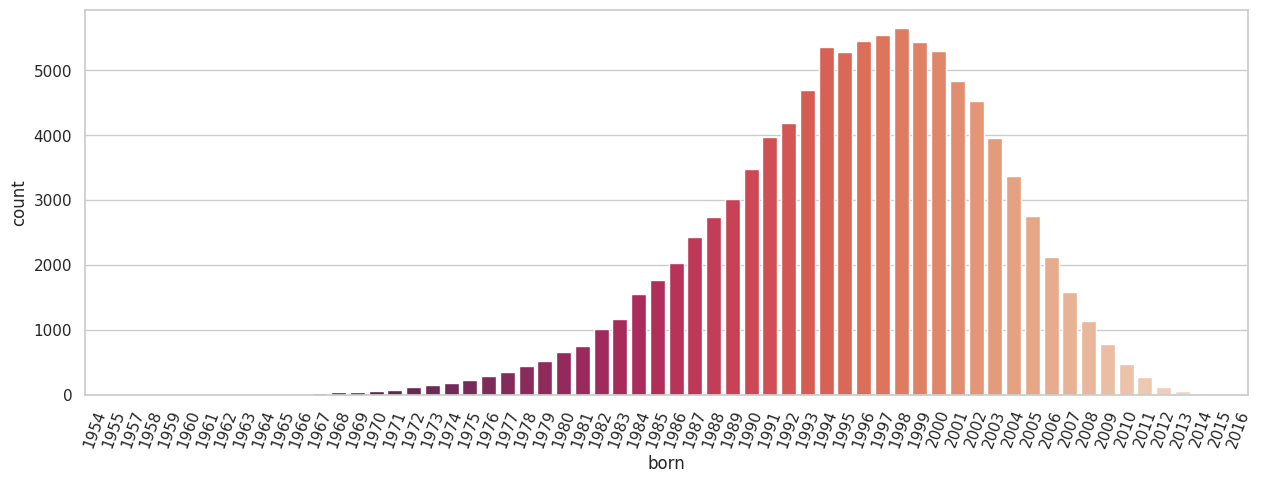

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.tick_params(axis='x', rotation=70)
sns.set(style="whitegrid")
ax = sns.countplot(x="born", data=customer, palette='rocket', orient='v')
plt.show()

## Umur

In [ ]:
from datetime import date
customer['age'] = round((((pd.to_datetime(date.today()) - customer['birthdate']).dt.days)/365), 0)
customer.head()

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,age,born
0,2870,Lala,Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,F,1996-06-14,iOS,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone; CPU iPhone OS 14_2_1 like Mac OS X,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21,28.0,1996
1,8193,Maimunah,Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,F,1993-08-16,Android,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android 2.2.1,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16,30.0,1993
2,7279,Bakiman,Simanjuntak,3250e5a3-1d23-4675-a647-3281879d42be,3250e5a3_1d23_4675_a647_3281879d42be@startupca...,M,1989-01-23,iOS,d13dde0a-6ae1-43c3-83a7-11bbb922730b,iPad; CPU iPad OS 4_2_1 like Mac OS X,-8.631607,116.428436,Nusa Tenggara Barat,Indonesia,2020-08-23,35.0,1989
3,88813,Cahyadi,Maheswara,df797edf-b465-4a80-973b-9fbb612260c2,df797edf_b465_4a80_973b_9fbb612260c2@zakyfound...,M,1991-01-05,iOS,f4c18515-c5be-419f-8142-f037be47c9cd,iPad; CPU iPad OS 14_2 like Mac OS X,1.299332,115.774934,Kalimantan Timur,Indonesia,2021-10-03,33.0,1991
4,82542,Irnanto,Wijaya,36ab08e1-03de-42a8-9e3b-59528c798824,36ab08e1_03de_42a8_9e3b_59528c798824@startupca...,M,2000-07-15,iOS,e46e4c36-4630-4736-8fcf-663db29ca3b0,iPhone; CPU iPhone OS 10_3_3 like Mac OS X,-2.980807,114.924675,Kalimantan Selatan,Indonesia,2021-04-11,23.0,2000


In [ ]:
customer['age'] = customer['age'].astype(int)
customer.head()

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,age,born
0,2870,Lala,Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,F,1996-06-14,iOS,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone; CPU iPhone OS 14_2_1 like Mac OS X,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21,28,1996
1,8193,Maimunah,Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,F,1993-08-16,Android,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android 2.2.1,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16,30,1993
2,7279,Bakiman,Simanjuntak,3250e5a3-1d23-4675-a647-3281879d42be,3250e5a3_1d23_4675_a647_3281879d42be@startupca...,M,1989-01-23,iOS,d13dde0a-6ae1-43c3-83a7-11bbb922730b,iPad; CPU iPad OS 4_2_1 like Mac OS X,-8.631607,116.428436,Nusa Tenggara Barat,Indonesia,2020-08-23,35,1989
3,88813,Cahyadi,Maheswara,df797edf-b465-4a80-973b-9fbb612260c2,df797edf_b465_4a80_973b_9fbb612260c2@zakyfound...,M,1991-01-05,iOS,f4c18515-c5be-419f-8142-f037be47c9cd,iPad; CPU iPad OS 14_2 like Mac OS X,1.299332,115.774934,Kalimantan Timur,Indonesia,2021-10-03,33,1991
4,82542,Irnanto,Wijaya,36ab08e1-03de-42a8-9e3b-59528c798824,36ab08e1_03de_42a8_9e3b_59528c798824@startupca...,M,2000-07-15,iOS,e46e4c36-4630-4736-8fcf-663db29ca3b0,iPhone; CPU iPhone OS 10_3_3 like Mac OS X,-2.980807,114.924675,Kalimantan Selatan,Indonesia,2021-04-11,23,2000


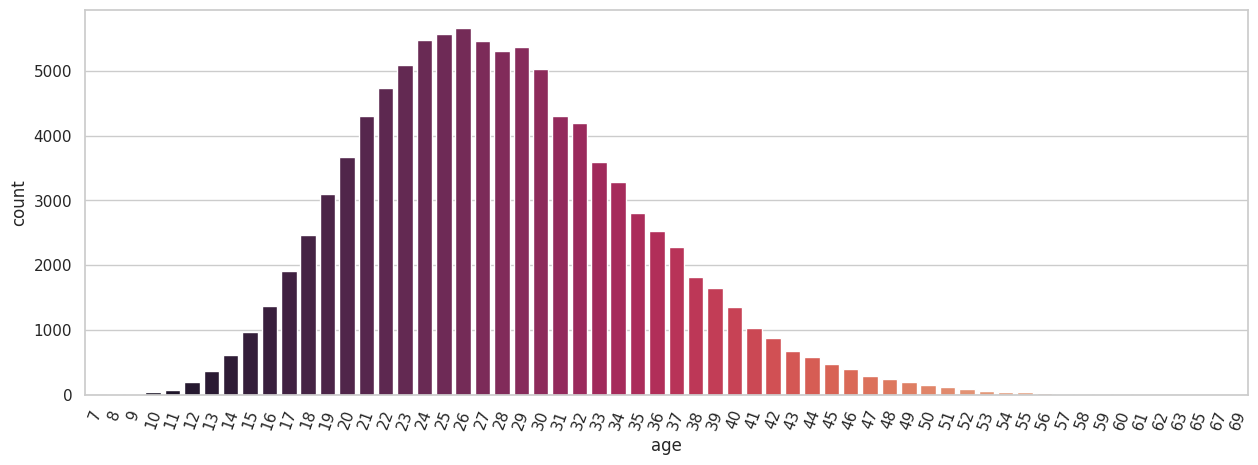

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.tick_params(axis='x', rotation=70)
sns.set(style="whitegrid")
ax = sns.countplot(x="age", data=customer, palette='rocket', orient='v')
plt.show()

## Merge all dataset ex click dan produk

In [ ]:
all_dataset = pd.merge(transactions, customer, left_on='customer_id', right_on='customer_id', how='left')
all_dataset.head(2)

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price,total_price,transaction_day,transaction_month,transaction_hour,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,age,born
0,2018-07-29 15:22:01.458193+00:00,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03 05:07:24.812676+00:00,-8.227893,111.969107,199832,54728,1,191247,191247,Sunday,July,15,Titin,Pratiwi,498c2a5e-bafe-42cc-94f9-2832ac5e1f6b,498c2a5e_bafe_42cc_94f9_2832ac5e1f6b@startupca...,F,2000-08-20,Android,d1b5c84a-7718-4b7b-b5a2-cfa23d7dd836,Android 8.0.0,-6.122897,106.876500,Jakarta Raya,Indonesia,2018-07-28,23,2000
1,2018-07-30 12:40:22.365620+00:00,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,None,10000,2018-08-03 01:29:03.415705+00:00,3.013470,107.802514,155526,16193,1,145526,145526,Monday,July,12,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,28,1996


In [ ]:
all_dataset.isnull().sum()

created_at                0
customer_id               0
booking_id                0
session_id                0
payment_method            0
payment_status            0
promo_amount              0
promo_code                0
shipment_fee              0
shipment_date_limit       0
shipment_location_lat     0
shipment_location_long    0
total_amount              0
product_id                0
quantity                  0
item_price                0
total_price               0
transaction_day           0
transaction_month         0
transaction_hour          0
first_name                0
last_name                 0
username                  0
email                     0
gender                    0
birthdate                 0
device_type               0
device_id                 0
device_version            0
home_location_lat         0
home_location_long        0
home_location             0
home_country              0
first_join_date           0
age                       0
born                

In [ ]:
# Mengelompokan berdasarkan kegiatan yang ada di event_name dan membuat feature Baru

# Homepage
homepage = click[(click['event_name'] == 'HOMEPAGE')]
homepage = homepage.groupby('session_id')['event_name'].count()
homepage = homepage.to_frame().rename(columns={"event_name": "homepage"}).reset_index()

# Scroll
scroll = click[(click['event_name'] == 'SCROLL')]
scroll = scroll.groupby('session_id')['event_name'].count()
scroll = scroll.to_frame().rename(columns={"event_name": "scroll"}).reset_index()

# Search
search = click[(click['event_name'] == 'SEARCH')]
search = search.groupby('session_id')['event_name'].count()
search = search.to_frame().rename(columns={"event_name": "search"}).reset_index()

# Item Detail
item_detail = click[(click['event_name'] == 'ITEM_DETAIL')]
item_detail = item_detail.groupby('session_id')['event_name'].count()
item_detail = item_detail.to_frame().rename(columns={"event_name": "item_detail"}).reset_index()

# Add To Cart
add_to_cart = click[(click['event_name'] == 'ADD_TO_CART')]
add_to_cart = add_to_cart.groupby('session_id')['event_name'].count()
add_to_cart = add_to_cart.to_frame().rename(columns={"event_name": "add_to_cart"}).reset_index()

# Add Promo
add_promo = click[(click['event_name'] == 'ADD_PROMO')]
add_promo = add_promo.groupby('session_id')['event_name'].count()
add_promo = add_promo.to_frame().rename(columns={"event_name": "add_promo"}).reset_index()

# click
click_event = click[(click['event_name'] == 'CLICK')]
click_event = click_event.groupby('session_id')['event_name'].count()
click_event = click_event.to_frame().rename(columns={"event_name": "click"}).reset_index()

# promo_page
promo_page = click[(click['event_name'] == 'PROMO_PAGE')]
promo_page = promo_page.groupby('session_id')['event_name'].count()
promo_page = promo_page.to_frame().rename(columns={"event_name": "promo_page"}).reset_index()

# Booking
booking = click[(click['event_name'] == 'BOOKING')]
booking = booking.groupby('session_id')['event_name'].count()
booking = booking.to_frame().rename(columns={"event_name": "booking"}).reset_index()

In [ ]:
# Menggabungkan Semua Feature Diatas

click_session = click[['session_id', 'event_time']].merge(homepage, on='session_id', how='left')
click_session = click_session.merge(scroll, on='session_id', how='left')
click_session = click_session.merge(search, on='session_id', how='left')
click_session = click_session.merge(item_detail, on='session_id', how='left')
click_session = click_session.merge(add_to_cart, on='session_id', how='left')
click_session = click_session.merge(add_promo, on='session_id', how='left')
click_session = click_session.merge(click_event, on='session_id', how='left')
click_session = click_session.merge(promo_page, on='session_id', how='left')
click_session = click_session.merge(booking, on='session_id', how='left')

In [ ]:
click_session.head()

,session_id,event_time,homepage,scroll,search,item_detail,add_to_cart,add_promo,click,promo_page,booking
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,2019-09-06T15:54:32.821085Z,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,2019-09-06T16:03:57.821085Z,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,2019-09-01T12:05:10.322763Z,2,1.0,1.0,3.0,1.0,NaN,NaN,NaN,1.0
3,7d440441-e67a-4d36-b324-80ffd636d166,2019-09-01T12:06:33.322763Z,2,1.0,1.0,3.0,1.0,NaN,NaN,NaN,1.0
4,7d440441-e67a-4d36-b324-80ffd636d166,2019-09-01T12:15:29.425431Z,2,1.0,1.0,3.0,1.0,NaN,NaN,NaN,1.0


In [ ]:
click_session.isnull().sum()

session_id           0
event_time           0
homepage             0
scroll         2291534
search         3200463
item_detail    2874141
add_to_cart     176561
add_promo      7419244
click          1392495
promo_page     5179752
booking         370598
dtype: int64

In [ ]:
# Mengubah kolom yang NaN menjadi 0
columns_to_fill_zero = ['scroll',	'search',	'item_detail',	'add_to_cart',	'add_promo',	'click',	'promo_page',	'booking']
click_session[columns_to_fill_zero] = click_session[columns_to_fill_zero].fillna(0)

In [ ]:
click_session.head()

,session_id,event_time,homepage,scroll,search,item_detail,add_to_cart,add_promo,click,promo_page,booking
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,2019-09-06T15:54:32.821085Z,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,2019-09-06T16:03:57.821085Z,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7d440441-e67a-4d36-b324-80ffd636d166,2019-09-01T12:05:10.322763Z,2,1.0,1.0,3.0,1.0,0.0,0.0,0.0,1.0
3,7d440441-e67a-4d36-b324-80ffd636d166,2019-09-01T12:06:33.322763Z,2,1.0,1.0,3.0,1.0,0.0,0.0,0.0,1.0
4,7d440441-e67a-4d36-b324-80ffd636d166,2019-09-01T12:15:29.425431Z,2,1.0,1.0,3.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
click_session.isnull().sum()

session_id     0
event_time     0
homepage       0
scroll         0
search         0
item_detail    0
add_to_cart    0
add_promo      0
click          0
promo_page     0
booking        0
dtype: int64

- HOMEPAGE: Pengguna masuk ke halaman utama platform saat mereka mulai sesi.
- SCROLL: Pengguna menggulir halaman untuk menjelajahi berbagai produk atau konten.
- SEARCH: Pengguna melakukan pencarian untuk produk tertentu atau kategori.
- ITEM_DETAIL: Pengguna mengklik pada item atau produk tertentu untuk melihat detailnya.
- ADD_TO_CART: Pengguna menambahkan item ke keranjang belanja.
- ADD_PROMO: Pengguna mungkin menambahkan promo atau kode diskon ke pesanan mereka.
- CLICK: Pengguna melakukan klik pada berbagai elemen, mungkin termasuk tautan atau gambar.
- PROMO_PAGE: Pengguna mengunjungi halaman promosi atau diskon khusus.

Disini terlihat bahwa dalam satu session customer melakukan banyak aktivitas pada waktu yang berbeda

#  **Feature Selection**

Menggabungkan dataset transaction (sukses saja) dengan click_session untuk melihat aktivitas dan informasi dari customer saat melakukan pemesanan

In [ ]:
new_transactions = pd.merge(transactions, customer_transaction_count, on='customer_id', how='left')

In [ ]:
new_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1254585 entries, 0 to 1254584
Data columns (total 33 columns):
 #   Column                  Non-Null Count    Dtype              
---  ------                  --------------    -----              
 0   created_at              1254585 non-null  datetime64[ns, UTC]
 1   customer_id             1254585 non-null  int64              
 2   booking_id              1254585 non-null  object             
 3   session_id              1254585 non-null  object             
 4   payment_method          1254585 non-null  category           
 5   payment_status          1254585 non-null  category           
 6   promo_amount            1254585 non-null  int64              
 7   promo_code              1254585 non-null  category           
 8   shipment_fee            1254585 non-null  int64              
 9   shipment_date_limit     1254585 non-null  datetime64[ns, UTC]
 10  shipment_location_lat   1254585 non-null  float64            
 11  shipment_lo

In [ ]:
columns_to_drop = ['total_amount_y', 'total_price_y', 'year', 'month']
new_transactions.drop(columns=columns_to_drop, inplace=True)

In [ ]:
new_transactions = new_transactions.rename(columns={'total_amount_x': 'total_amount'})
new_transactions = new_transactions.rename(columns={'total_price_x': 'total_price'})

In [ ]:
new_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1254585 entries, 0 to 1254584
Data columns (total 29 columns):
 #   Column                  Non-Null Count    Dtype              
---  ------                  --------------    -----              
 0   created_at              1254585 non-null  datetime64[ns, UTC]
 1   customer_id             1254585 non-null  int64              
 2   booking_id              1254585 non-null  object             
 3   session_id              1254585 non-null  object             
 4   payment_method          1254585 non-null  category           
 5   payment_status          1254585 non-null  category           
 6   promo_amount            1254585 non-null  int64              
 7   promo_code              1254585 non-null  category           
 8   shipment_fee            1254585 non-null  int64              
 9   shipment_date_limit     1254585 non-null  datetime64[ns, UTC]
 10  shipment_location_lat   1254585 non-null  float64            
 11  shipment_lo

In [ ]:
# Menggabungkan Transaction (Sukses Saja) dengan Feature Selection Sebelumnya
trans_success = new_transactions[new_transactions['payment_status'] == 'Success']

trans_click = trans_success.merge(click_session, on='session_id', how='left')
trans_click.head()

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price,total_price,transaction_day,transaction_month,transaction_hour,total_transactions,first_transaction,latest_transaction,total_quantity,total_shipment_fee,total_promo_amount,recency,first_join_date,tenure,event_time,homepage,scroll,search,item_detail,add_to_cart,add_promo,click,promo_page,booking
0,2018-07-29 15:22:01.458193+00:00,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03 05:07:24.812676+00:00,-8.227893,111.969107,199832,54728,1,191247,191247,Sunday,July,15,1,2018-07-29,2018-07-29,1,10000,1415,1463,2018-07-28,49.0,2018-07-29 14:41:48.913621+00:00,4.0,0.0,1.0,2.0,4.0,1.0,7.0,5.0,1.0
1,2018-07-29 15:22:01.458193+00:00,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03 05:07:24.812676+00:00,-8.227893,111.969107,199832,54728,1,191247,191247,Sunday,July,15,1,2018-07-29,2018-07-29,1,10000,1415,1463,2018-07-28,49.0,2018-07-29 14:43:45.913621+00:00,4.0,0.0,1.0,2.0,4.0,1.0,7.0,5.0,1.0
2,2018-07-29 15:22:01.458193+00:00,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03 05:07:24.812676+00:00,-8.227893,111.969107,199832,54728,1,191247,191247,Sunday,July,15,1,2018-07-29,2018-07-29,1,10000,1415,1463,2018-07-28,49.0,2018-07-29 14:45:20.913621+00:00,4.0,0.0,1.0,2.0,4.0,1.0,7.0,5.0,1.0
3,2018-07-29 15:22:01.458193+00:00,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03 05:07:24.812676+00:00,-8.227893,111.969107,199832,54728,1,191247,191247,Sunday,July,15,1,2018-07-29,2018-07-29,1,10000,1415,1463,2018-07-28,49.0,2018-07-29 15:22:01.458193+00:00,4.0,0.0,1.0,2.0,4.0,1.0,7.0,5.0,1.0
4,2018-07-29 15:22:01.458193+00:00,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03 05:07:24.812676+00:00,-8.227893,111.969107,199832,54728,1,191247,191247,Sunday,July,15,1,2018-07-29,2018-07-29,1,10000,1415,1463,2018-07-28,49.0,2018-07-29 14:43:19.913621+00:00,4.0,0.0,1.0,2.0,4.0,1.0,7.0,5.0,1.0


###Mencoba menghapus feature yang tidak diperlukan

In [ ]:
ex_session = trans_click.copy()
columns_to_drop = ['booking_id', 'session_id']
ex_session.drop(columns=columns_to_drop, inplace=True)

In [ ]:
ex_session = ex_session.drop(columns=['event_time'])

In [ ]:
columns_to_drop = ['shipment_date_limit', 'shipment_location_lat', 'shipment_location_long']
ex_session.drop(columns=columns_to_drop, inplace=True)

In [ ]:
ex_session['created_at'] = pd.to_datetime(ex_session['created_at'].dt.strftime("%Y-%m-%d"))

In [ ]:
ex_session.head()

,created_at,customer_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,total_amount,product_id,quantity,item_price,total_price,transaction_day,transaction_month,transaction_hour,total_transactions,first_transaction,latest_transaction,total_quantity,total_shipment_fee,total_promo_amount,recency,first_join_date,tenure,homepage,scroll,search,item_detail,add_to_cart,add_promo,click,promo_page,booking
0,2018-07-29,5868,Debit Card,Success,1415,WEEKENDSERU,10000,199832,54728,1,191247,191247,Sunday,July,15,1,2018-07-29,2018-07-29,1,10000,1415,1463,2018-07-28,49.0,4.0,0.0,1.0,2.0,4.0,1.0,7.0,5.0,1.0
1,2018-07-29,5868,Debit Card,Success,1415,WEEKENDSERU,10000,199832,54728,1,191247,191247,Sunday,July,15,1,2018-07-29,2018-07-29,1,10000,1415,1463,2018-07-28,49.0,4.0,0.0,1.0,2.0,4.0,1.0,7.0,5.0,1.0
2,2018-07-29,5868,Debit Card,Success,1415,WEEKENDSERU,10000,199832,54728,1,191247,191247,Sunday,July,15,1,2018-07-29,2018-07-29,1,10000,1415,1463,2018-07-28,49.0,4.0,0.0,1.0,2.0,4.0,1.0,7.0,5.0,1.0
3,2018-07-29,5868,Debit Card,Success,1415,WEEKENDSERU,10000,199832,54728,1,191247,191247,Sunday,July,15,1,2018-07-29,2018-07-29,1,10000,1415,1463,2018-07-28,49.0,4.0,0.0,1.0,2.0,4.0,1.0,7.0,5.0,1.0
4,2018-07-29,5868,Debit Card,Success,1415,WEEKENDSERU,10000,199832,54728,1,191247,191247,Sunday,July,15,1,2018-07-29,2018-07-29,1,10000,1415,1463,2018-07-28,49.0,4.0,0.0,1.0,2.0,4.0,1.0,7.0,5.0,1.0


In [ ]:
ex_session.duplicated().sum()

18686996

In [ ]:
ex_session.drop_duplicates(inplace=True)

In [ ]:
ex_session.head()

,created_at,customer_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,total_amount,product_id,quantity,item_price,total_price,transaction_day,transaction_month,transaction_hour,total_transactions,first_transaction,latest_transaction,total_quantity,total_shipment_fee,total_promo_amount,recency,first_join_date,tenure,homepage,scroll,search,item_detail,add_to_cart,add_promo,click,promo_page,booking
0,2018-07-29,5868,Debit Card,Success,1415,WEEKENDSERU,10000,199832,54728,1,191247,191247,Sunday,July,15,1,2018-07-29,2018-07-29,1,10000,1415,1463,2018-07-28,49.0,4.0,0.0,1.0,2.0,4.0,1.0,7.0,5.0,1.0
25,2018-07-30,4774,Credit Card,Success,0,None,10000,155526,16193,1,145526,145526,Monday,July,12,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,3.0,3.0,1.0,1.0,1.0,0.0,3.0,2.0,1.0
40,2018-09-15,4774,OVO,Success,0,None,10000,550696,53686,4,135174,540696,Saturday,September,11,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
44,2018-11-01,4774,Credit Card,Success,0,None,0,271012,20228,1,271012,271012,Thursday,November,11,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,2.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0
53,2018-12-18,4774,Credit Card,Success,0,None,0,198753,55220,1,198753,198753,Tuesday,December,11,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
ex_session.shape

(1201035, 33)

In [ ]:
ex_session.loc[ex_session['customer_id'] == 4774]

,created_at,customer_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,total_amount,product_id,quantity,item_price,total_price,transaction_day,transaction_month,transaction_hour,total_transactions,first_transaction,latest_transaction,total_quantity,total_shipment_fee,total_promo_amount,recency,first_join_date,tenure,homepage,scroll,search,item_detail,add_to_cart,add_promo,click,promo_page,booking
25,2018-07-30,4774,Credit Card,Success,0,None,10000,155526,16193,1,145526,145526,Monday,July,12,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,3.0,3.0,1.0,1.0,1.0,0.0,3.0,2.0,1.0
40,2018-09-15,4774,OVO,Success,0,None,10000,550696,53686,4,135174,540696,Saturday,September,11,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
44,2018-11-01,4774,Credit Card,Success,0,None,0,271012,20228,1,271012,271012,Thursday,November,11,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,2.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0
53,2018-12-18,4774,Credit Card,Success,0,None,0,198753,55220,1,198753,198753,Tuesday,December,11,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
57,2019-02-03,4774,Debit Card,Success,6369,WEEKENDMANTAP,5000,181865,59620,1,183234,183234,Sunday,February,11,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,2.0,0.0,1.0,0.0,3.0,1.0,1.0,0.0,1.0
66,2019-03-22,4774,Credit Card,Success,0,None,10000,306599,53136,1,296599,296599,Friday,March,11,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,1.0,1.0,1.0,2.0,4.0,0.0,2.0,0.0,1.0
78,2019-05-08,4774,Credit Card,Success,0,None,10000,153913,14142,1,143913,143913,Wednesday,May,11,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
84,2019-06-24,4774,Credit Card,Success,4019,AZ2022,10000,370757,12282,1,364776,364776,Monday,June,12,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,3.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0
95,2019-08-10,4774,Credit Card,Success,9072,WEEKENDSERU,10000,1295740,53051,1,292052,292052,Saturday,August,12,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,1.0,1.0,1.0,0.0,7.0,1.0,1.0,0.0,1.0
108,2019-08-10,4774,Credit Card,Success,9072,WEEKENDSERU,10000,1295740,46352,1,241945,241945,Saturday,August,12,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,1.0,1.0,1.0,0.0,7.0,1.0,1.0,0.0,1.0


## Fix Dataset

In [ ]:
feature = ex_session.copy()

In [ ]:
feature.head()

,created_at,customer_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,total_amount,product_id,quantity,item_price,total_price,transaction_day,transaction_month,transaction_hour,total_transactions,first_transaction,latest_transaction,total_quantity,total_shipment_fee,total_promo_amount,recency,first_join_date,tenure,homepage,scroll,search,item_detail,add_to_cart,add_promo,click,promo_page,booking
0,2018-07-29,5868,Debit Card,Success,1415,WEEKENDSERU,10000,199832,54728,1,191247,191247,Sunday,July,15,1,2018-07-29,2018-07-29,1,10000,1415,1463,2018-07-28,49.0,4.0,0.0,1.0,2.0,4.0,1.0,7.0,5.0,1.0
25,2018-07-30,4774,Credit Card,Success,0,None,10000,155526,16193,1,145526,145526,Monday,July,12,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,3.0,3.0,1.0,1.0,1.0,0.0,3.0,2.0,1.0
40,2018-09-15,4774,OVO,Success,0,None,10000,550696,53686,4,135174,540696,Saturday,September,11,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
44,2018-11-01,4774,Credit Card,Success,0,None,0,271012,20228,1,271012,271012,Thursday,November,11,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,2.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0
53,2018-12-18,4774,Credit Card,Success,0,None,0,198753,55220,1,198753,198753,Tuesday,December,11,43,2018-07-30,2022-06-09,64,390000,123186,52,2018-07-28,49.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Churn Label

In [ ]:
# Melihat rentang waktu dalam kolom 'created_at'.
print(min(feature['created_at']))
print(max(feature['created_at']))

2016-06-30 00:00:00
2022-07-31 00:00:00


In [ ]:
# Melakukan agregasi untuk membuat fitur yang relevan dengan tujuan project yang akan digunakan didalam modelling
agg_all_slices = pd.DataFrame()

agg_all_slices = feature.groupby(['customer_id']).agg(
            last_transaction = pd.NamedAgg(column = 'created_at', aggfunc=max),
            total_amount=pd.NamedAgg(column='total_amount', aggfunc=sum),
            total_promo_code=pd.NamedAgg(column='promo_amount', aggfunc='nunique'),
            avg_shipment=pd.NamedAgg(column='shipment_fee', aggfunc='mean'),
            avg_homepage=pd.NamedAgg(column='homepage', aggfunc='mean'),
            avg_scroll=pd.NamedAgg(column='scroll', aggfunc='mean'),
            avg_click=pd.NamedAgg(column='click', aggfunc='mean'),
            item_detail=pd.NamedAgg(column='item_detail', aggfunc='mean'),
            avg_promo_page=pd.NamedAgg(column='promo_page', aggfunc='mean'),
            avg_search=pd.NamedAgg(column='search', aggfunc='mean'),
            avg_add_to_cart=pd.NamedAgg(column='add_to_cart', aggfunc='mean'),
            avg_add_promo=pd.NamedAgg(column='add_promo', aggfunc='mean'),
        ).reset_index()

In [ ]:
agg_all_slices.head()

,customer_id,last_transaction,total_amount,total_promo_code,avg_shipment,avg_homepage,avg_scroll,avg_click,item_detail,avg_promo_page,avg_search,avg_add_to_cart,avg_add_promo
0,3,2022-06-26,45467583,26,6811.594203,2.217391,1.507246,2.405797,1.246377,0.855072,1.072464,3.724638,0.536232
1,8,2022-05-15,4758601,2,6875.000000,11.750000,2.625000,3.625000,4.375000,0.750000,1.125000,2.250000,0.125000
2,9,2022-05-28,4113630,1,5625.000000,1.375000,1.250000,2.375000,1.000000,0.750000,1.000000,3.000000,0.000000
3,11,2022-03-07,197533,1,15000.000000,3.000000,0.000000,1.000000,2.000000,2.000000,0.000000,4.000000,1.000000
4,15,2022-01-05,6447246,5,10000.000000,1.888889,0.666667,1.444444,0.333333,0.555556,0.777778,5.000000,0.444444


In [ ]:
agg_all_slices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50242 entries, 0 to 50241
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       50242 non-null  int64         
 1   last_transaction  50242 non-null  datetime64[ns]
 2   total_amount      50242 non-null  int64         
 3   total_promo_code  50242 non-null  int64         
 4   avg_shipment      50242 non-null  float64       
 5   avg_homepage      50241 non-null  float64       
 6   avg_scroll        50241 non-null  float64       
 7   avg_click         50241 non-null  float64       
 8   item_detail       50241 non-null  float64       
 9   avg_promo_page    50241 non-null  float64       
 10  avg_search        50241 non-null  float64       
 11  avg_add_to_cart   50241 non-null  float64       
 12  avg_add_promo     50241 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(3)
memory usage: 5.0 MB


In [ ]:
"""
Membuat pengelompokan data customer untuk menentukan churn berdasarkan kapan terakhir customer aktif
dilihat dari apakah customer setelah 12 bulan aktif (observation window) masih aktif selama 6 bulan
ke depan (performance window). Dan apa faktor yang paling mempengaruhi seorang customer loyal
"""
agg_all_slices['last_transaction'] = pd.to_datetime(agg_all_slices['last_transaction'])
agg_all_slices.set_index('last_transaction', inplace=True)
start_date = pd.to_datetime('2016-06-30')
end_date = pd.to_datetime('2022-07-31')
window_size = pd.DateOffset(months=12)
window_ranges = []
window_performance = []

current_date = start_date
while current_date <= end_date:
    window_end = current_date + window_size
    window_data = agg_all_slices[(agg_all_slices.index >= current_date) & (agg_all_slices.index < window_end)]

    total_amount_mean = window_data['total_amount'].mean()
    total_promo_code_sum = window_data['total_promo_code'].sum()

    window_ranges.append((current_date, window_end))
    window_performance.append({
        'Total Amount Mean': total_amount_mean,
        'Total Promo Code Sum': total_promo_code_sum,
    })

    current_date = window_end

for i, (start, end) in enumerate(window_ranges):
    print(f"Window {i + 1}: {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}")
    print("Performance Metrics:")
    for key, value in window_performance[i].items():
        print(f"  {key}: {value}")
    print("=" * 30)

Window 1: 2016-06-30 to 2017-06-30
Performance Metrics:
  Total Amount Mean: 1435699.6957055214
  Total Promo Code Sum: 815
Window 2: 2017-06-30 to 2018-06-30
Performance Metrics:
  Total Amount Mean: 1355400.6104702752
  Total Promo Code Sum: 1127
Window 3: 2018-06-30 to 2019-06-30
Performance Metrics:
  Total Amount Mean: 1773929.950892857
  Total Promo Code Sum: 1357
Window 4: 2019-06-30 to 2020-06-30
Performance Metrics:
  Total Amount Mean: 2645892.199315329
  Total Promo Code Sum: 3342
Window 5: 2020-06-30 to 2021-06-30
Performance Metrics:
  Total Amount Mean: 3495985.728669559
  Total Promo Code Sum: 9373
Window 6: 2021-06-30 to 2022-06-30
Performance Metrics:
  Total Amount Mean: 24455370.522400618
  Total Promo Code Sum: 188009
Window 7: 2022-06-30 to 2023-06-30
Performance Metrics:
  Total Amount Mean: 67403695.97370727
  Total Promo Code Sum: 153393


In [ ]:
# Buat label untuk customer yang tidak aktif dalam rentang 6 bulan dianggap churn
lag_time = pd.DateOffset(months=6)
agg_all_slices['target'] = (agg_all_slices.index + lag_time <= end_date).astype(int)
agg_all_slices.head()
print(agg_all_slices['target'].unique())

[0 1]


In [ ]:
agg_all_slices

,customer_id,total_amount,total_promo_code,avg_shipment,avg_homepage,avg_scroll,avg_click,item_detail,avg_promo_page,avg_search,avg_add_to_cart,avg_add_promo,target
last_transaction,,,,,,,,,,,,,
2022-06-26,3,45467583,26,6811.594203,2.217391,1.507246,2.405797,1.246377,0.855072,1.072464,3.724638,0.536232,0
2022-05-15,8,4758601,2,6875.000000,11.750000,2.625000,3.625000,4.375000,0.750000,1.125000,2.250000,0.125000,0
2022-05-28,9,4113630,1,5625.000000,1.375000,1.250000,2.375000,1.000000,0.750000,1.000000,3.000000,0.000000,0
2022-03-07,11,197533,1,15000.000000,3.000000,0.000000,1.000000,2.000000,2.000000,0.000000,4.000000,1.000000,0
2022-01-05,15,6447246,5,10000.000000,1.888889,0.666667,1.444444,0.333333,0.555556,0.777778,5.000000,0.444444,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-25,99992,14033384,3,10588.235294,1.235294,1.117647,2.117647,0.117647,0.058824,0.588235,3.764706,0.117647,0
2022-07-29,99995,54351495,14,10320.512821,3.115385,2.025641,3.692308,2.538462,0.576923,2.192308,1.948718,0.243590,0
2020-04-25,99997,226461,1,10000.000000,1.000000,1.000000,2.000000,0.000000,1.000000,0.000000,4.000000,0.000000,1


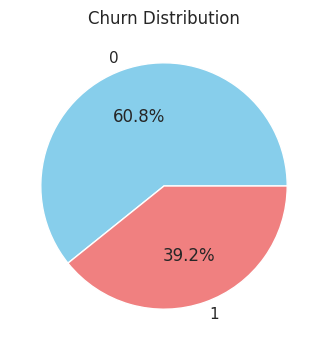

In [ ]:
# Menghitung jumlah data untuk setiap kategori churn dan tidak churn
churn_counts = agg_all_slices['target'].value_counts()
plt.figure(figsize=(6, 4))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Churn Distribution')
plt.show()

## Data Preprocessing

In [ ]:
agg_all_slices.isnull().sum()

customer_id         0
total_amount        0
total_promo_code    0
avg_shipment        0
avg_homepage        1
avg_scroll          1
avg_click           1
item_detail         1
avg_promo_page      1
avg_search          1
avg_add_to_cart     1
avg_add_promo       1
target              0
dtype: int64

In [ ]:
# Mengubah data NaN menjadi 0
fill_missing = ['avg_homepage',	'avg_scroll',	'avg_click',	'item_detail',	'avg_promo_page',	'avg_search',	'avg_add_to_cart',	'avg_add_promo']
agg_all_slices[fill_missing] = agg_all_slices[fill_missing].fillna(0)

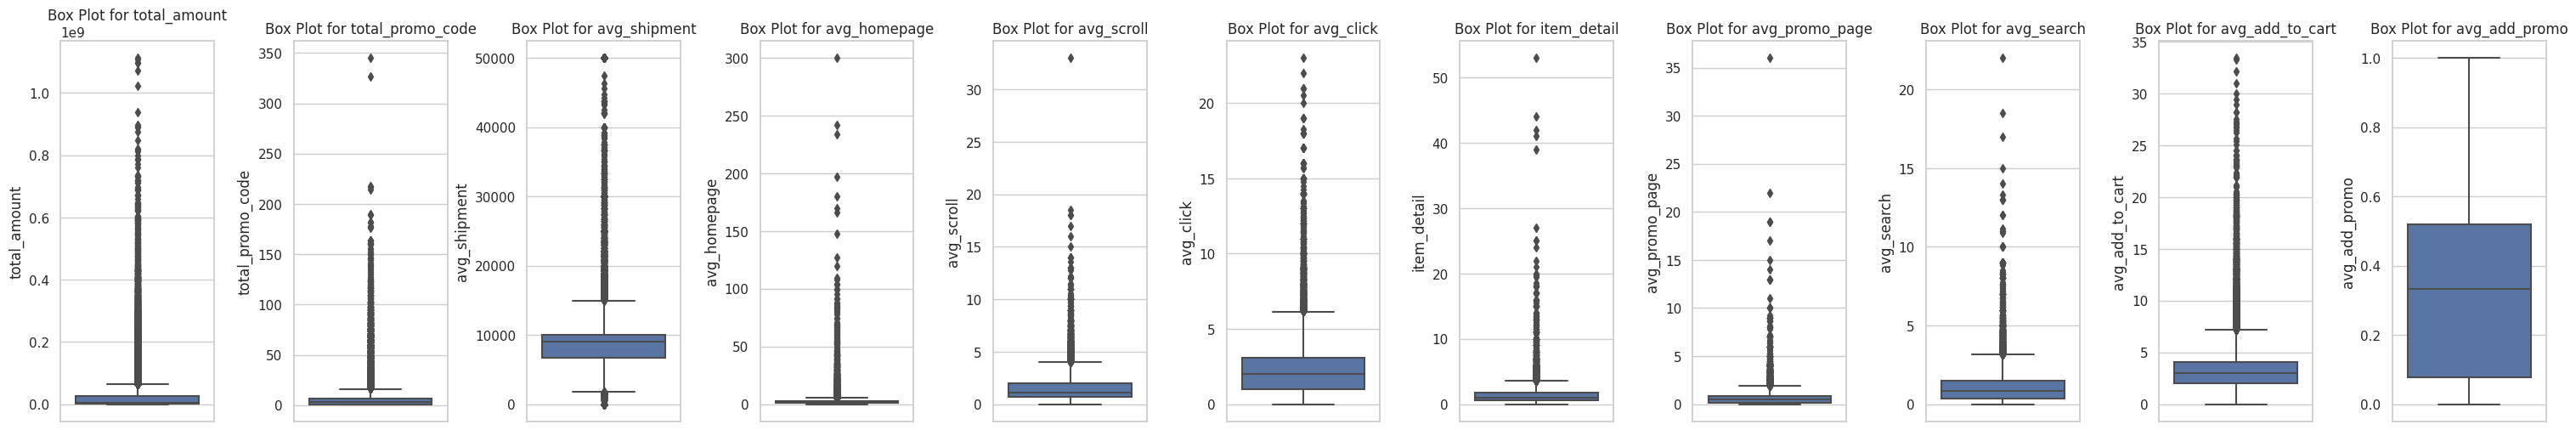

In [ ]:
# Menampilkan outlier menggunakan boxplot
columns_to_use = ['total_amount', 'total_promo_code', 'avg_shipment', 'avg_homepage', 'avg_scroll', 'avg_click', 'item_detail', 'avg_promo_page', 'avg_search', 'avg_add_to_cart', 'avg_add_promo']

def plot_boxplots(data, columns, figsize=(30, 5)):
    fig, axs = plt.subplots(ncols=len(columns), figsize=figsize)

    for i, column in enumerate(columns):
        sns.boxplot(y=column, data=data, ax=axs[i], whis=1.5)

        axs[i].set_title(f'Box Plot for {column}')
        axs[i].set_xlabel('')

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
    plt.show()

plot_boxplots(agg_all_slices, columns_to_use)

In [ ]:
agg_all_slices.shape

(50242, 13)

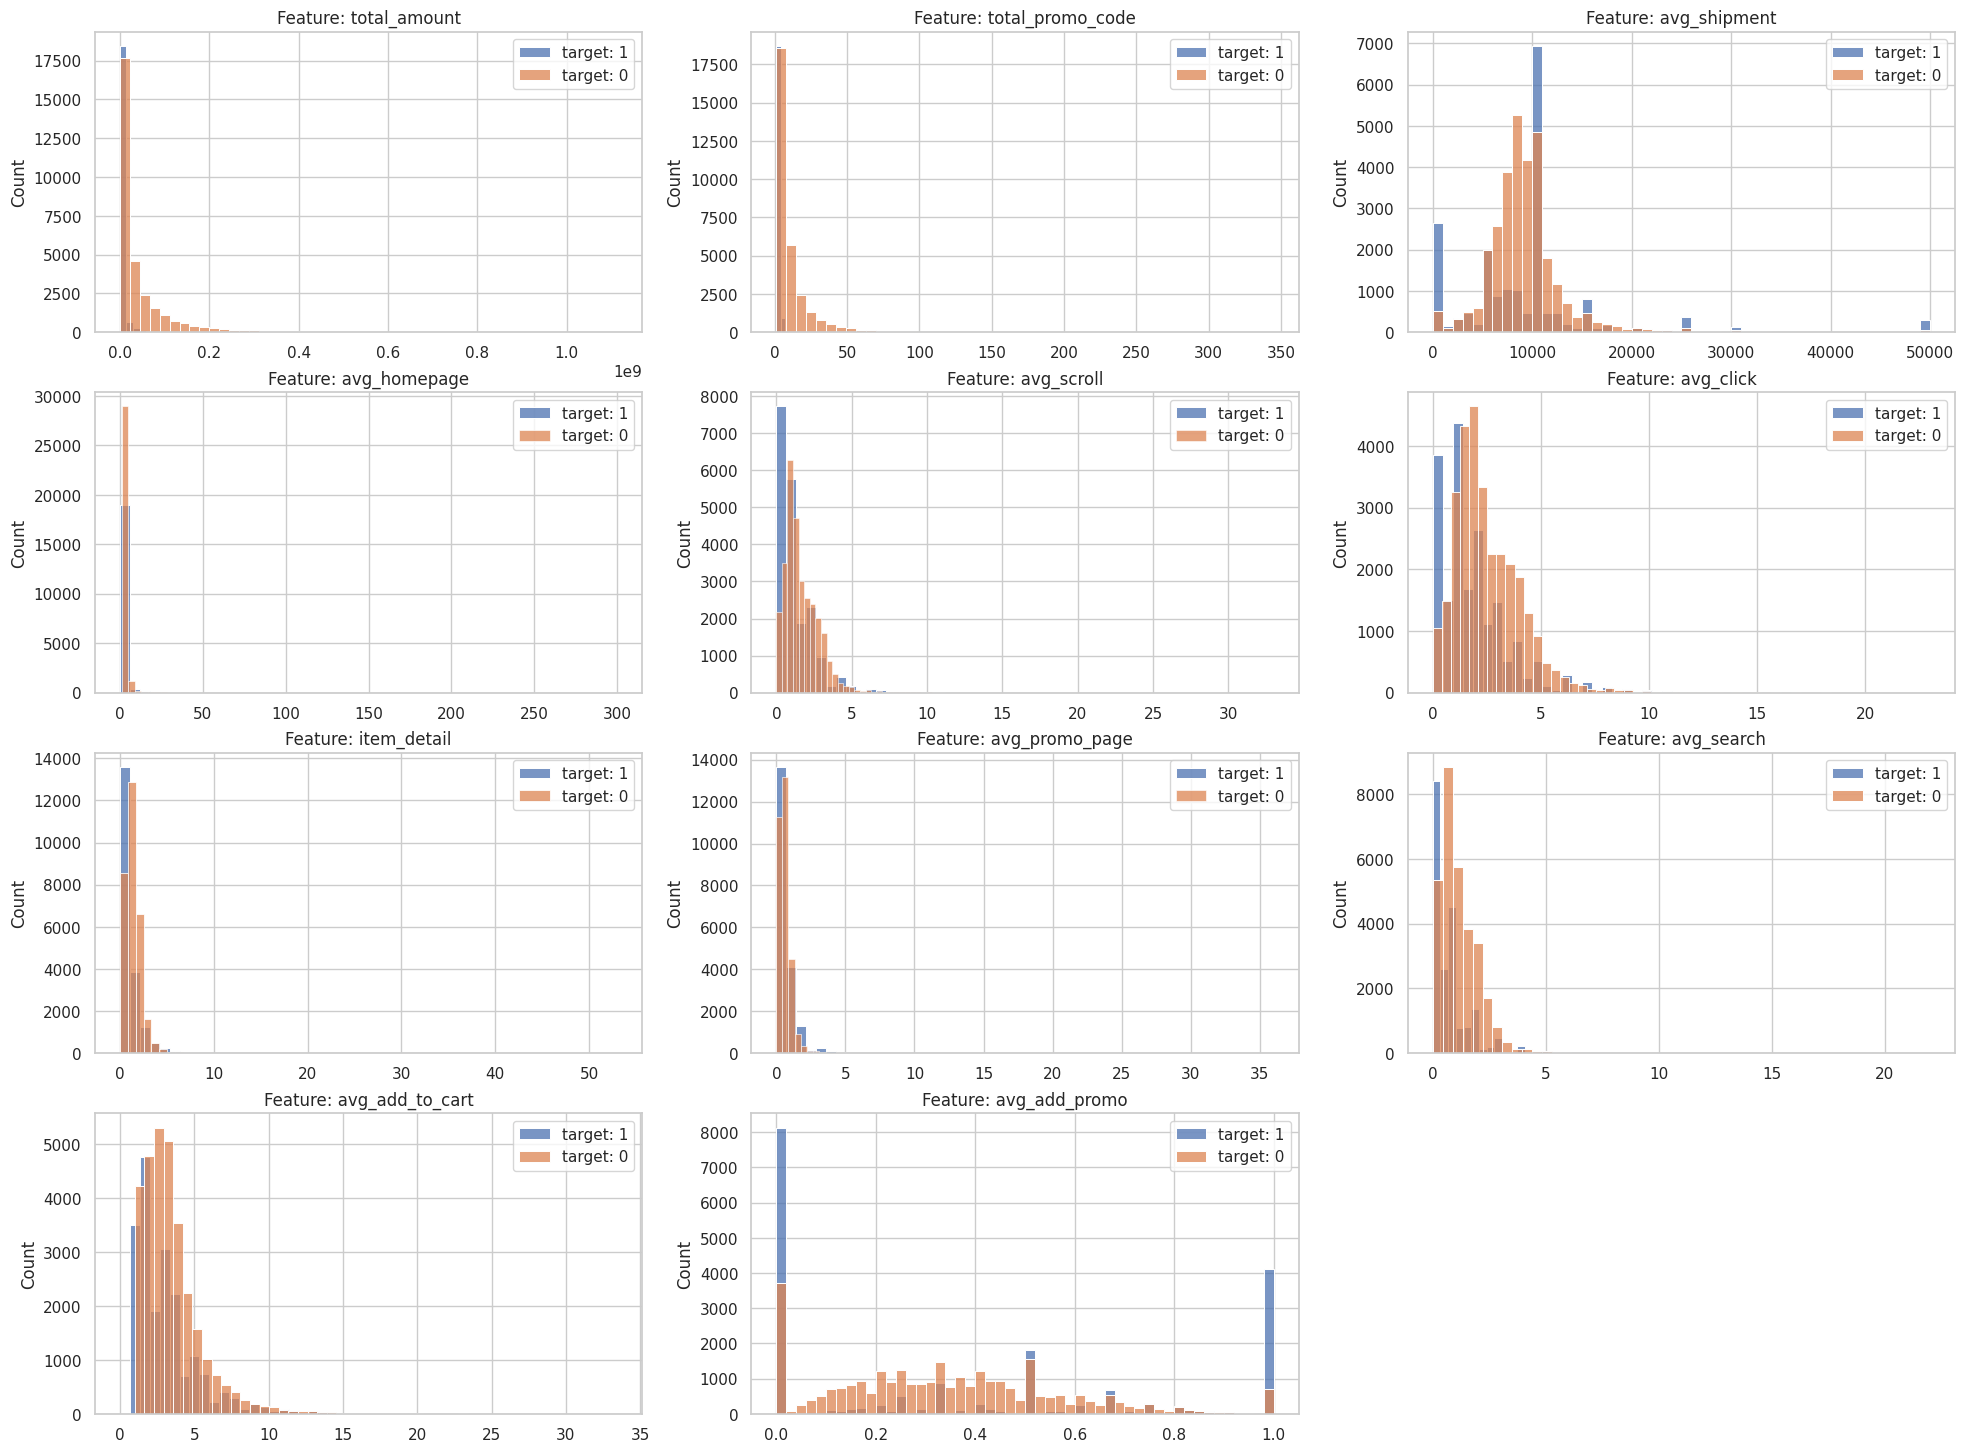

In [ ]:
# Fungsi untuk membuat subplot distribusi fitur-fitur tertentu
def plot_distribution(columns_to_use, data):
    plt.figure(figsize=(24, 32))
    gs = gridspec.GridSpec(7, 3)

    for i, column in enumerate(columns_to_use):
        ax = plt.subplot(gs[i])
        sns.histplot(data[column][data.target == 1], bins=50, label='target: 1')
        sns.histplot(data[column][data.target == 0], bins=50, label='target: 0')
        ax.set_xlabel('')
        ax.set_title('Feature: ' + str(column))
        ax.legend()

    plt.show()

# Memanggil fungsi dengan argumen yang sesuai
plot_distribution(columns_to_use, agg_all_slices)

In [ ]:
# Calculate Q1 and Q3 for the selected numeric columns
Q1 = agg_all_slices[columns_to_use].quantile(0.25)
Q3 = agg_all_slices[columns_to_use].quantile(0.75)

# Calculate IQR, maximum, and minimum for outlier handling
IQR = Q3 - Q1
maximum = Q3 + (1.5 * IQR)
minimum = Q1 - (1.5 * IQR)

# Handle outliers by capping values that exceed the maximum or fall below the minimum
agg_all_slices[columns_to_use] = agg_all_slices[columns_to_use].clip(lower=minimum, upper=maximum, axis=1)

# Display the agg_all_slices distribution after outlier handling
print('\nagg_all_slices Distribution after Outliers being Handled:')
print(agg_all_slices[columns_to_use].describe())


agg_all_slices Distribution after Outliers being Handled:
       total_amount  total_promo_code  avg_shipment  avg_homepage  \
count  5.024200e+04      50242.000000  50242.000000  50242.000000   
mean   1.699111e+07          5.107918   8694.626489      2.261007   
std    2.230502e+07          5.067929   3349.794233      1.137240   
min    2.745000e+04          1.000000   1810.344828      0.000000   
25%    8.854670e+05          1.000000   6724.137931      1.409091   
50%    4.964144e+06          3.000000   9090.909091      2.000000   
75%    2.594351e+07          7.000000  10000.000000      2.979274   
max    6.353056e+07         16.000000  14913.793103      5.334550   

         avg_scroll     avg_click   item_detail  avg_promo_page    avg_search  \
count  50242.000000  50242.000000  50242.000000    50242.000000  50242.000000   
mean       1.408140      2.217771      1.201032        0.552277      0.978922   
std        1.067171      1.518455      0.893286        0.489514      0.81939

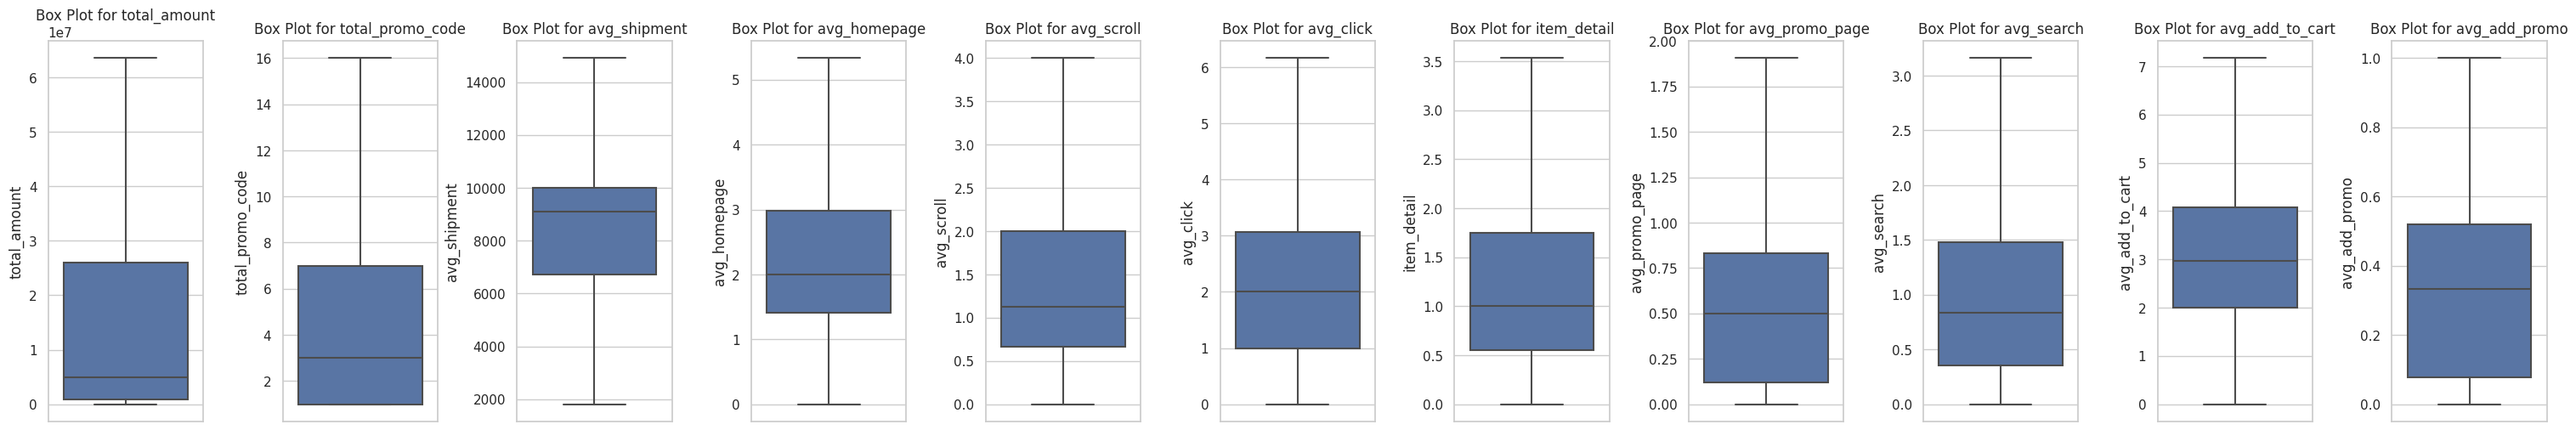

In [ ]:
plot_boxplots(agg_all_slices, columns_to_use)

In [ ]:
agg_all_slices.shape

(50242, 13)

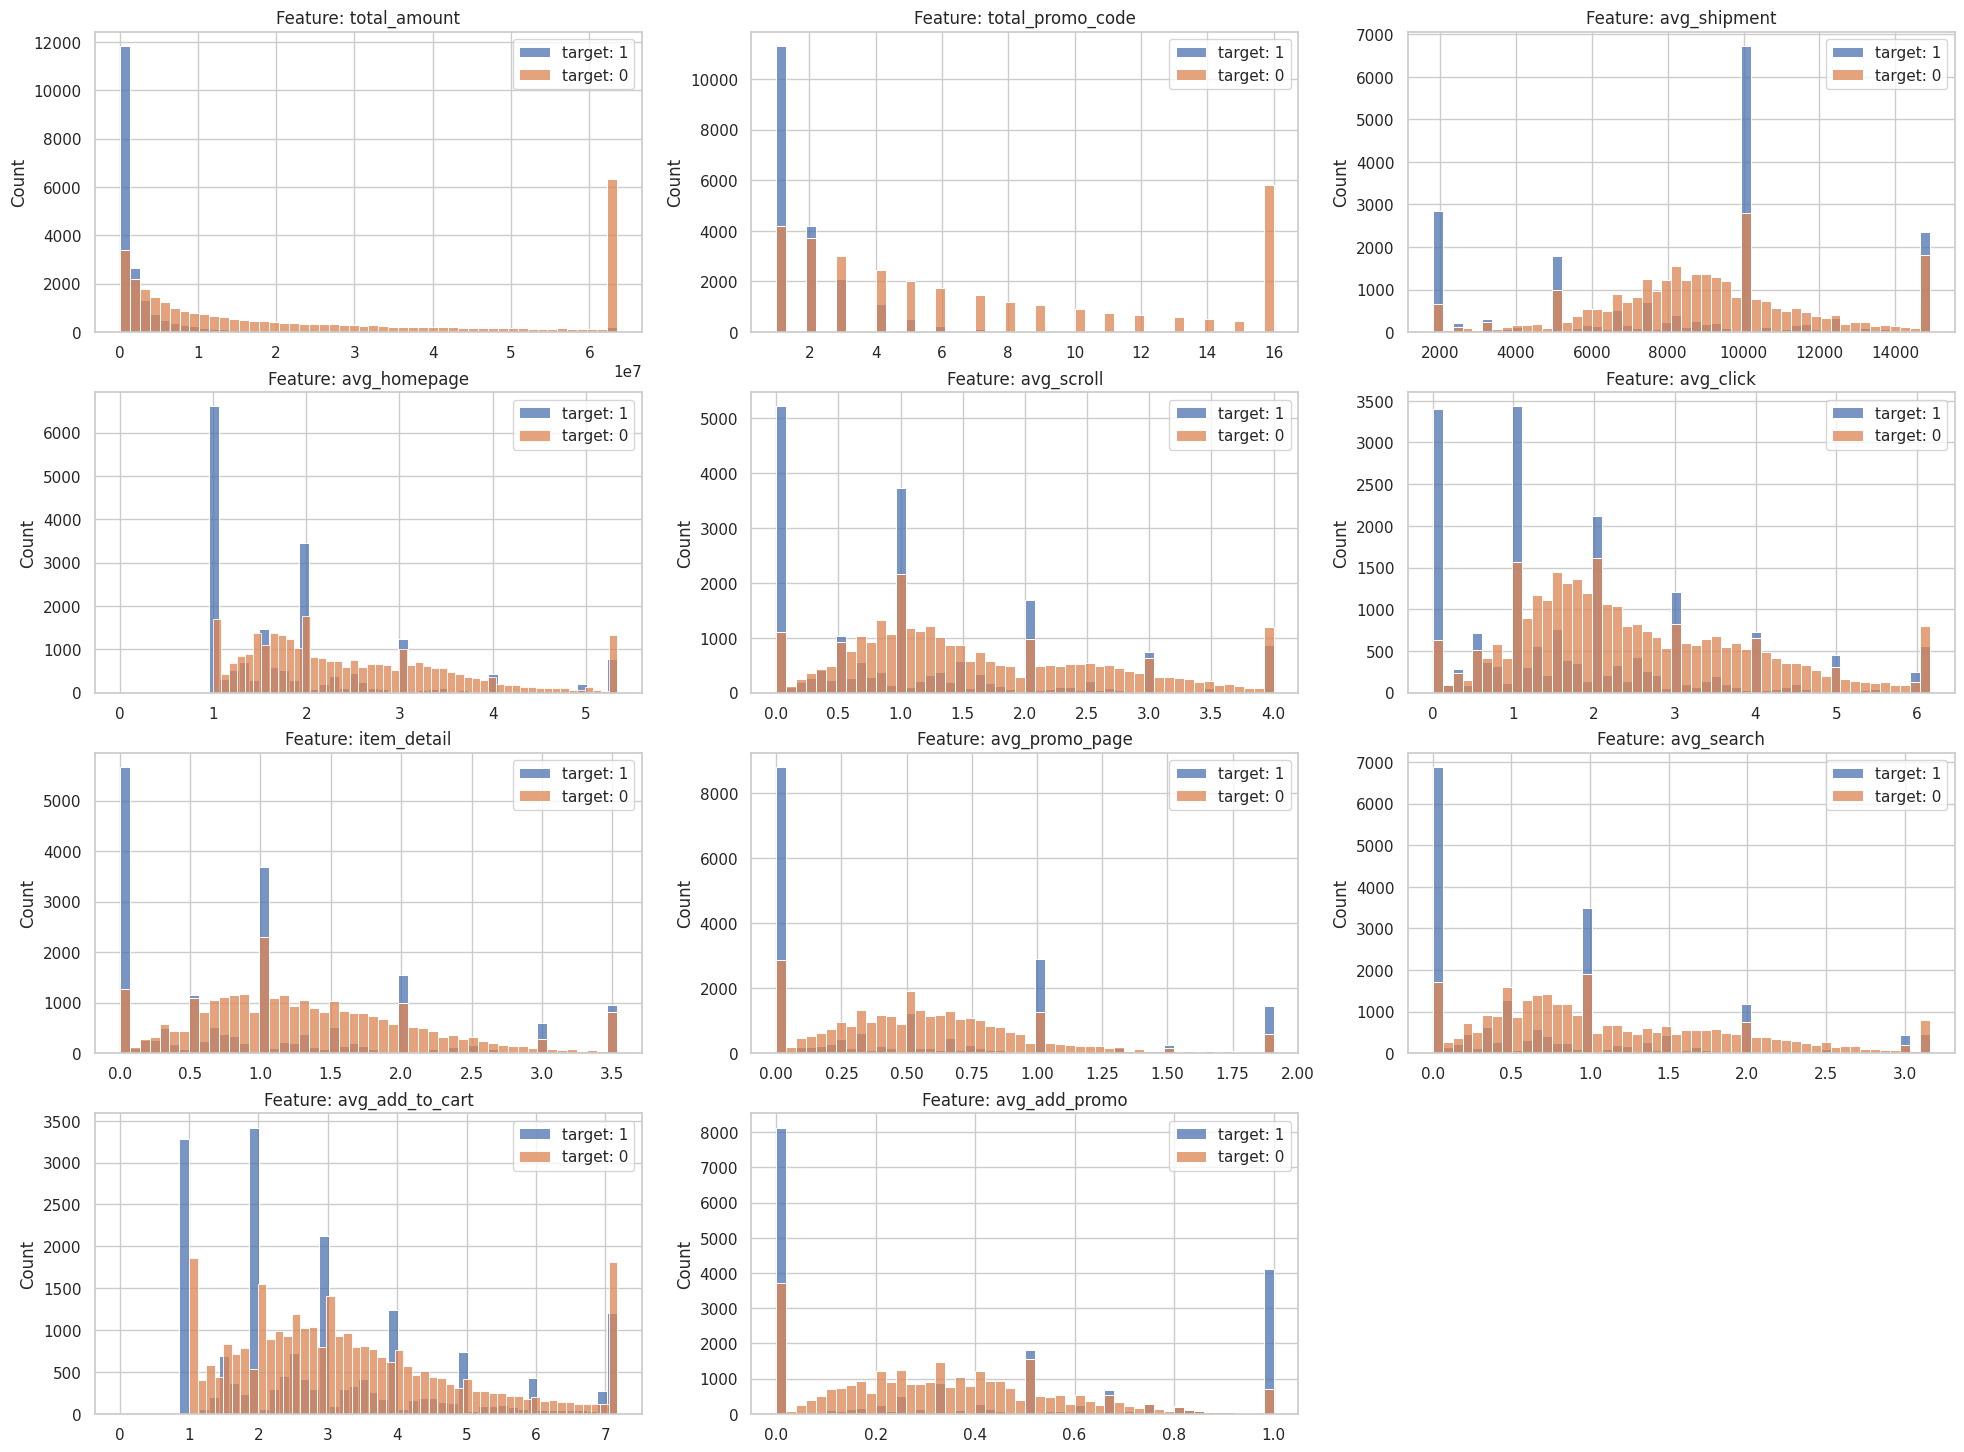

In [ ]:
plot_distribution(columns_to_use, agg_all_slices)

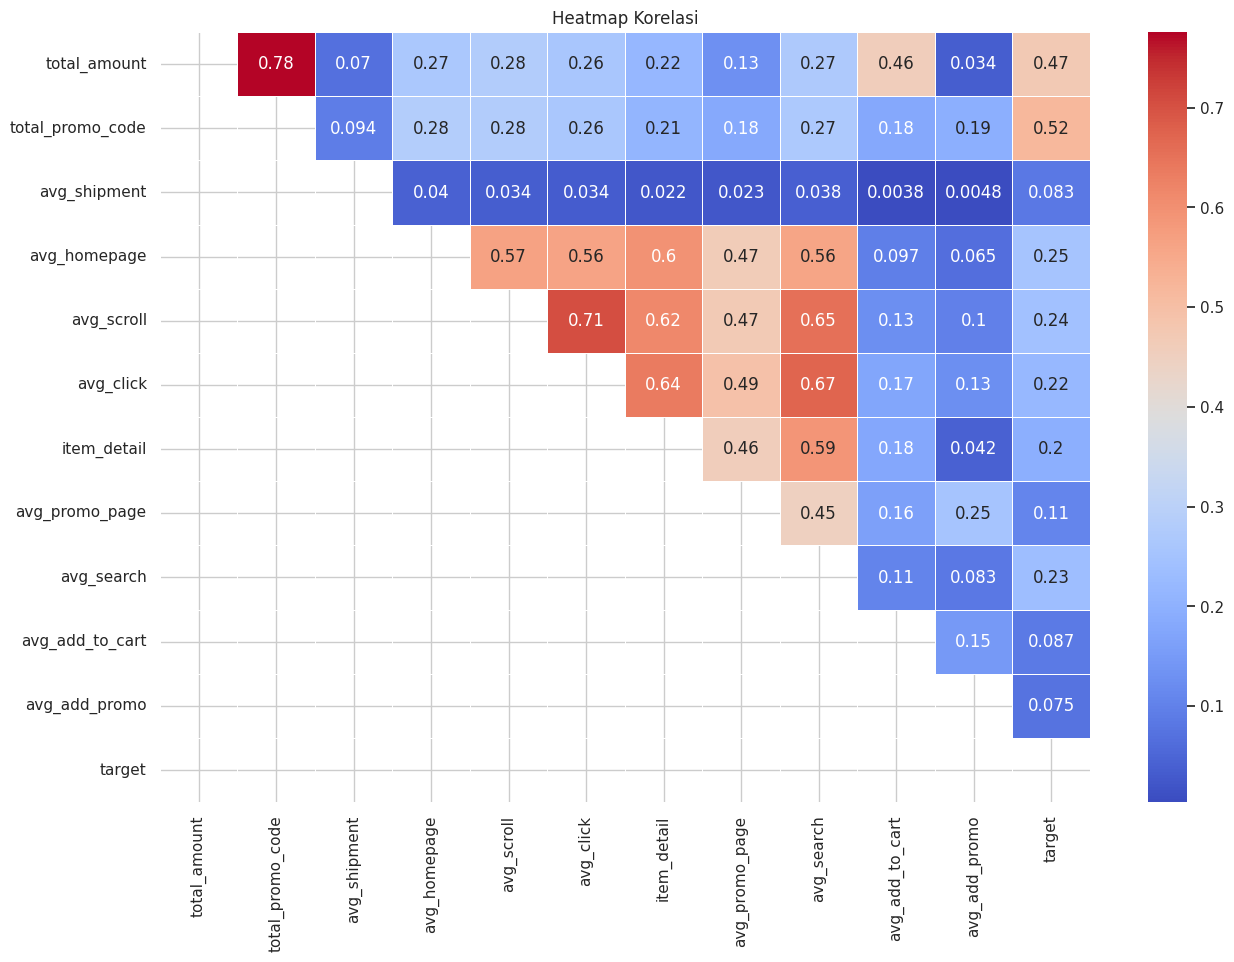

In [ ]:
# Menghilangkan kolom yang tidak diinginkan
selected_columns = agg_all_slices.drop(['customer_id'], axis=1)

# Menghitung korelasi
correlation_matrix = selected_columns.corr().abs()
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Membuat heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(upper, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap Korelasi')
plt.show()

# **Machine Learning**

In [ ]:
agg_all_slices.head(5)

,customer_id,total_amount,total_promo_code,avg_shipment,avg_homepage,avg_scroll,avg_click,item_detail,avg_promo_page,avg_search,avg_add_to_cart,avg_add_promo,target
last_transaction,,,,,,,,,,,,,
2022-06-26,3,45467583.0,16,6811.594203,2.217391,1.507246,2.405797,1.246377,0.855072,1.072464,3.724638,0.536232,0
2022-05-15,8,4758601.0,2,6875.000000,5.334550,2.625000,3.625000,3.534041,0.750000,1.125000,2.250000,0.125000,0
2022-05-28,9,4113630.0,1,5625.000000,1.375000,1.250000,2.375000,1.000000,0.750000,1.000000,3.000000,0.000000,0
2022-03-07,11,197533.0,1,14913.793103,3.000000,0.000000,1.000000,2.000000,1.906863,0.000000,4.000000,1.000000,0
2022-01-05,15,6447246.0,5,10000.000000,1.888889,0.666667,1.444444,0.333333,0.555556,0.777778,5.000000,0.444444,1


In [ ]:
agg_all_slices['target'].unique()

array([0, 1])

In [ ]:
agg_all_slices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50242 entries, 2022-06-26 to 2016-10-12
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       50242 non-null  int64  
 1   total_amount      50242 non-null  float64
 2   total_promo_code  50242 non-null  int64  
 3   avg_shipment      50242 non-null  float64
 4   avg_homepage      50242 non-null  float64
 5   avg_scroll        50242 non-null  float64
 6   avg_click         50242 non-null  float64
 7   item_detail       50242 non-null  float64
 8   avg_promo_page    50242 non-null  float64
 9   avg_search        50242 non-null  float64
 10  avg_add_to_cart   50242 non-null  float64
 11  avg_add_promo     50242 non-null  float64
 12  target            50242 non-null  int64  
dtypes: float64(10), int64(3)
memory usage: 5.4 MB


Inisialisasi split data

In [ ]:
# Asumsikan bahwa 'target' adalah kolom target Anda
# agg_all_slices['last_active'] = agg_all_slices['last_active'].astype(int)
X = agg_all_slices.drop('target', axis=1)
y = agg_all_slices['target']

# Bagi data menjadi training set dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Cross Validation

In [ ]:
# Membuat stratified K-fold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Hyperparameter Tuning otomatis menggunakan Grid Search

**Decision Tree Classifier**

In [ ]:
dt = DecisionTreeClassifier(random_state=42)

# Membuat grid search untuk hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(dt, param_grid, cv=cv, scoring='accuracy')

# Melakukan fitting dan mencari model terbaik
grid_search.fit(X_train, y_train)

# Memprediksi data test
y_pred = grid_search.predict(X_test)

# Menampilkan parameter terbaik
print("Best Parameters: ", grid_search.best_params_)

# Menampilkan skor terbaik
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Score:  0.8189484573230509


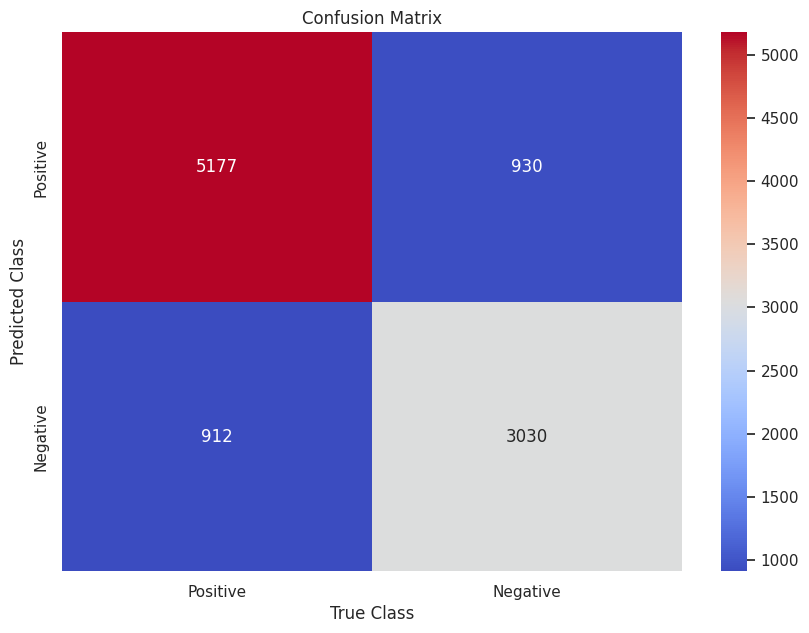

In [ ]:
# Membuat confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Membuat plot confusion matrix menggunakan seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

plt.show()

In [ ]:
# Membuat classification report
report = classification_report(y_test, y_pred)

print("Classification Report: ")
print(report)

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      6107
           1       0.77      0.77      0.77      3942

    accuracy                           0.82     10049
   macro avg       0.81      0.81      0.81     10049
weighted avg       0.82      0.82      0.82     10049



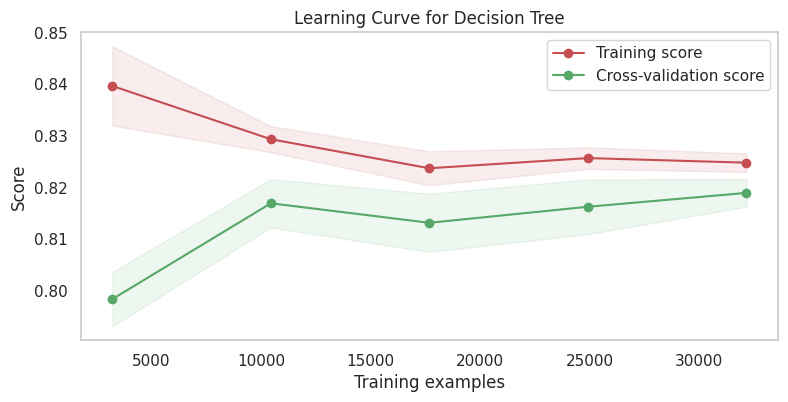

In [ ]:
# Menampilkan learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(grid_search.best_estimator_, 'Learning Curve for Decision Tree', X_train, y_train, cv=cv)
plt.show()

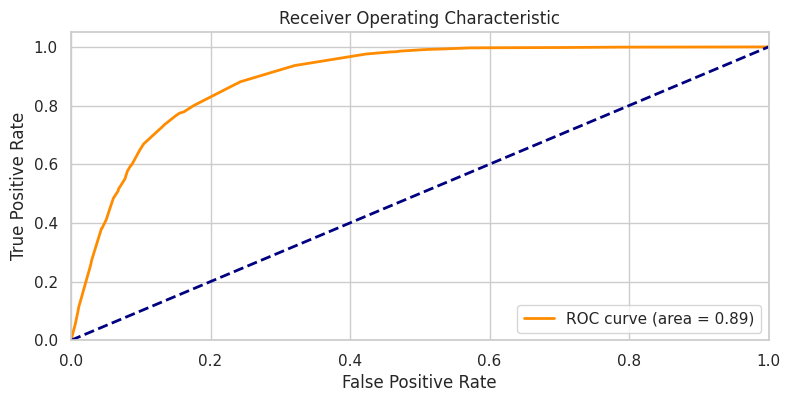

In [ ]:
# Memprediksi probabilitas kelas positif
y_score = grid_search.predict_proba(X_test)[:,1]

# Menghitung nilai-nilai untuk ROC curve dan AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Membuat plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

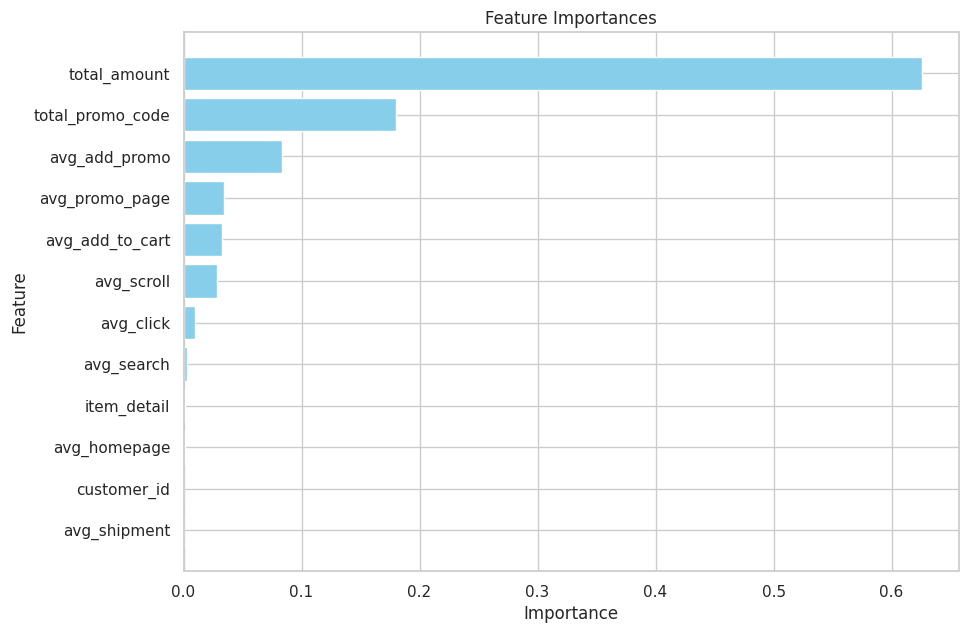

In [ ]:
# Mendapatkan feature importances
importances = grid_search.best_estimator_.feature_importances_

# Membuat DataFrame untuk menampilkan feature importances
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Mengurutkan feature importances
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Membuat plot feature importances
plt.figure(figsize=(10, 7))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

**Random Forests**

In [ ]:
rf = RandomForestClassifier(random_state=42)

# Membuat grid search untuk hyperparameter tuning
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=cv, scoring='accuracy')

# Melakukan fitting dan mencari model terbaik
grid_search_rf.fit(X_train, y_train)

# Memprediksi data test
y_pred_rf = grid_search_rf.predict(X_test)

# Menampilkan parameter terbaik
print("Best Parameters: ", grid_search_rf.best_params_)

# Menampilkan skor terbaik
print("Best Score: ", grid_search_rf.best_score_)

Best Parameters:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}
Best Score:  0.8330553827523023


In [ ]:
# Membuat classification report
report_rf = classification_report(y_test, y_pred_rf)

print("Classification Report: ")
print(report_rf)

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      6107
           1       0.78      0.81      0.79      3942

    accuracy                           0.83     10049
   macro avg       0.83      0.83      0.83     10049
weighted avg       0.84      0.83      0.83     10049



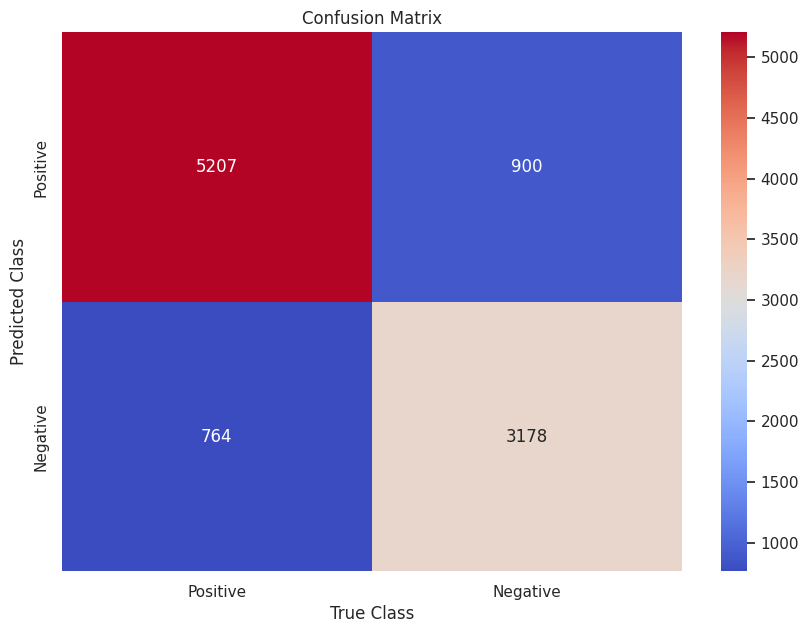

In [ ]:
# Membuat confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Membuat plot confusion matrix menggunakan seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

plt.show()

In [ ]:
# Memprediksi probabilitas kelas positif
y_score_rf = grid_search_rf.predict_proba(X_test)[:,1]

# Menghitung nilai-nilai untuk ROC curve dan AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

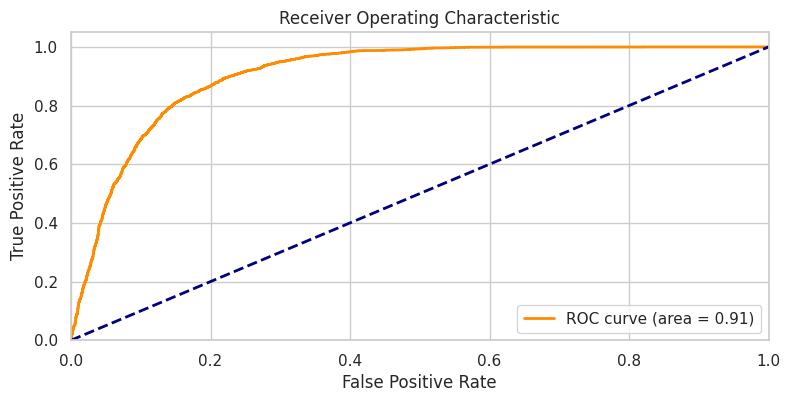

In [ ]:
# Membuat plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

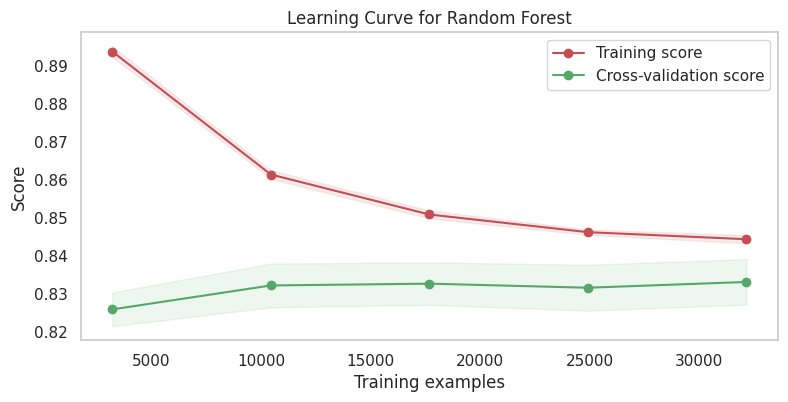

In [ ]:
# Plot learning curve
plot_learning_curve(grid_search_rf.best_estimator_, 'Learning Curve for Random Forest', X_train, y_train, cv=cv)
plt.show()

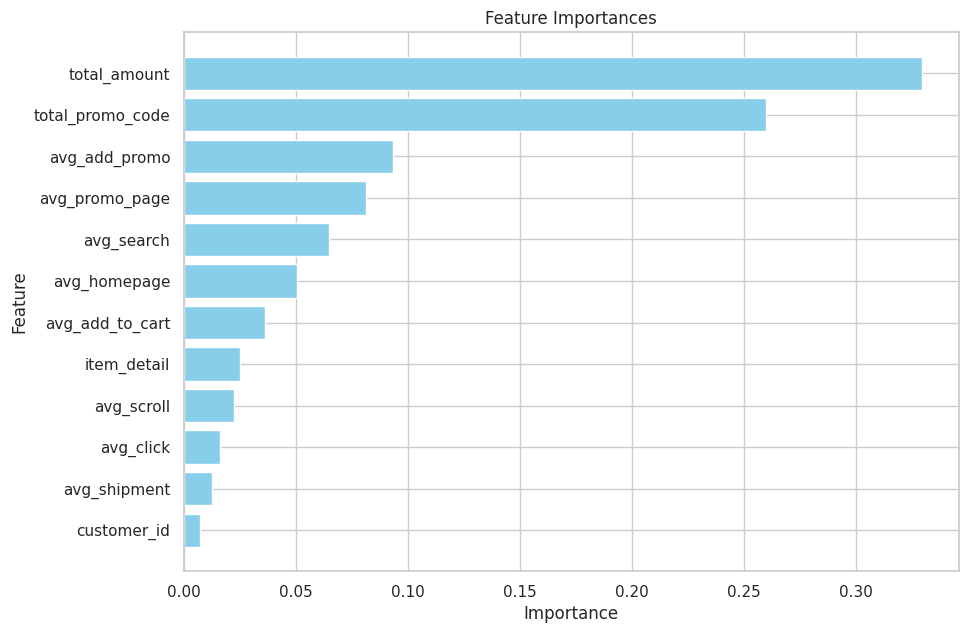

In [ ]:
# Mendapatkan feature importances
importances_rf = grid_search_rf.best_estimator_.feature_importances_

# Membuat DataFrame untuk menampilkan feature importances
feature_importances_rf = pd.DataFrame({'feature': X_train.columns, 'importance': importances_rf})

# Mengurutkan feature importances
feature_importances_rf = feature_importances_rf.sort_values('importance', ascending=False)

# Membuat plot feature importances
plt.figure(figsize=(10, 7))
plt.barh(feature_importances_rf['feature'], feature_importances_rf['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

**XGBoost**

In [ ]:
# Membuat model XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Membuat grid search untuk hyperparameter tuning
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 5, 6],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1]
}

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=cv, scoring='accuracy')

# Melakukan fitting dan mencari model terbaik
grid_search_xgb.fit(X_train, y_train)

# Memprediksi data test
y_pred_xgb = grid_search_xgb.predict(X_test)

# Menampilkan parameter terbaik
print("Best Parameters: ", grid_search_xgb.best_params_)

# Menampilkan skor terbaik
print("Best Score: ", grid_search_xgb.best_score_)

Best Parameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500, 'subsample': 1}
Best Score:  0.839250560707395


In [ ]:
# Membuat classification report
report_xgb = classification_report(y_test, y_pred_xgb)

print("Classification Report: ")
print(report_xgb)

Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      6107
           1       0.77      0.82      0.80      3942

    accuracy                           0.84     10049
   macro avg       0.83      0.83      0.83     10049
weighted avg       0.84      0.84      0.84     10049



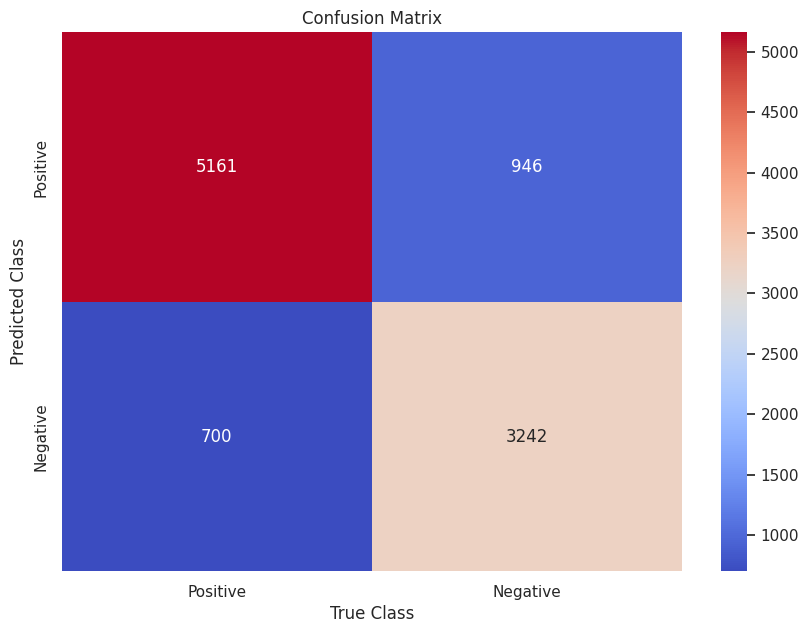

In [ ]:
# Membuat confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Membuat plot confusion matrix menggunakan seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

plt.show()

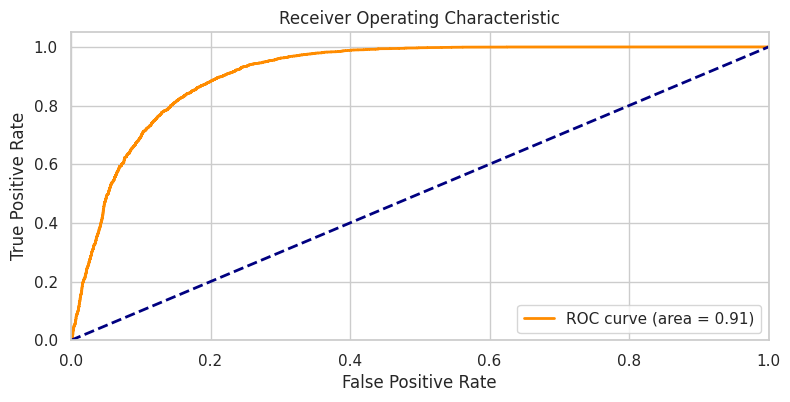

In [ ]:
# Memprediksi probabilitas kelas positif
y_score_xgb = grid_search_xgb.predict_proba(X_test)[:,1]

# Menghitung nilai-nilai untuk ROC curve dan AUC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Membuat plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

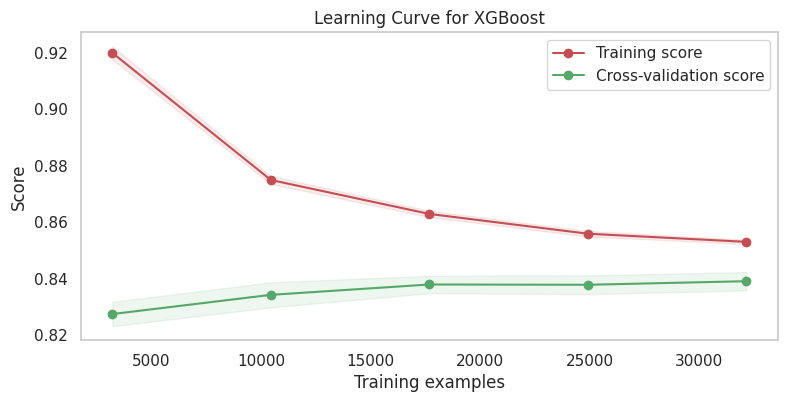

In [ ]:
# Plot learning curve
plot_learning_curve(grid_search_xgb.best_estimator_, 'Learning Curve for XGBoost', X_train, y_train, cv=cv)
plt.show()

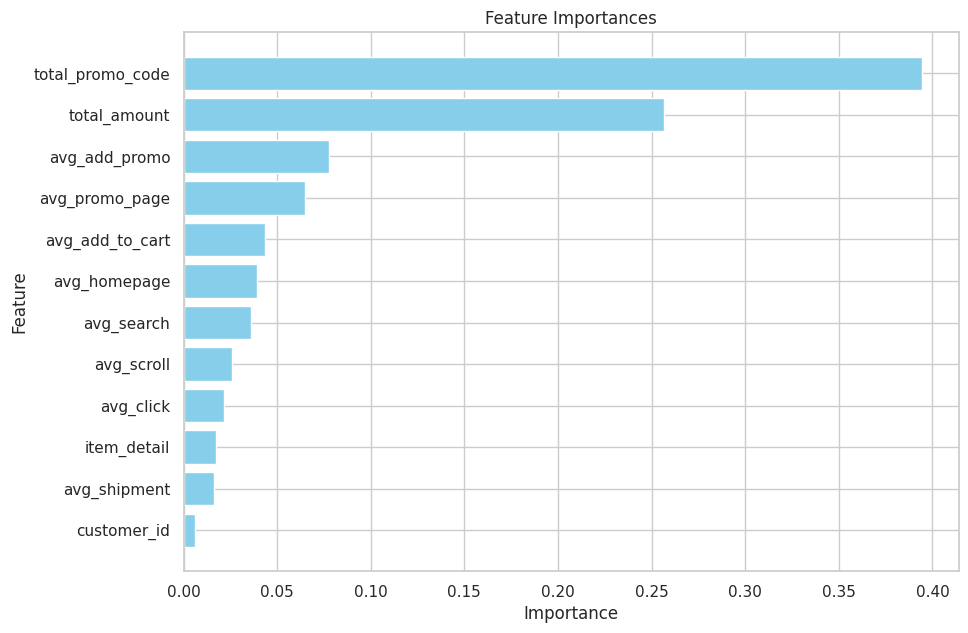

In [ ]:
# Mendapatkan feature importances
importances_xgb = grid_search_xgb.best_estimator_.feature_importances_

# Membuat DataFrame untuk menampilkan feature importances
feature_importances_xgb = pd.DataFrame({'feature': X_train.columns, 'importance': importances_xgb})

# Mengurutkan feature importances
feature_importances_xgb = feature_importances_xgb.sort_values('importance', ascending=False)

# Membuat plot feature importances
plt.figure(figsize=(10, 7))
plt.barh(feature_importances_xgb['feature'], feature_importances_xgb['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
#from google.colab import files
#agg_all_slices.to_csv('agg_all_slices.csv', index=False)
#files.download('agg_all_slices.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>